In [1]:
%load_ext autoreload
%autoreload 2

In [29]:
from data_utils import *
from eda_utils import *
from train_utils import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
import pickle
import os

import warnings
# Ignore warnings
warnings.filterwarnings("ignore")

# Data Preprocessing

## Dataset creation

In [3]:
phyt_cod_path = 'data/PHYT_COD_ForDvirLafer.csv'
phyto_path = 'data/Phyto4DvirLafer.csv'

biomass_by_week_year_group = get_biomass_data(phyt_cod_path, phyto_path)

In [4]:
fp_path = 'data/FP_2017_ForDvirLafer.csv'

fp_df = get_fluorprobe_data(fp_path)

## Fluorprobe outliers exploration

In [5]:
fp_df['depth_discrete'] = fp_df['depth'].apply(lambda x: min(biomass_by_week_year_group['Depth'], key=lambda y: abs(y - x)))

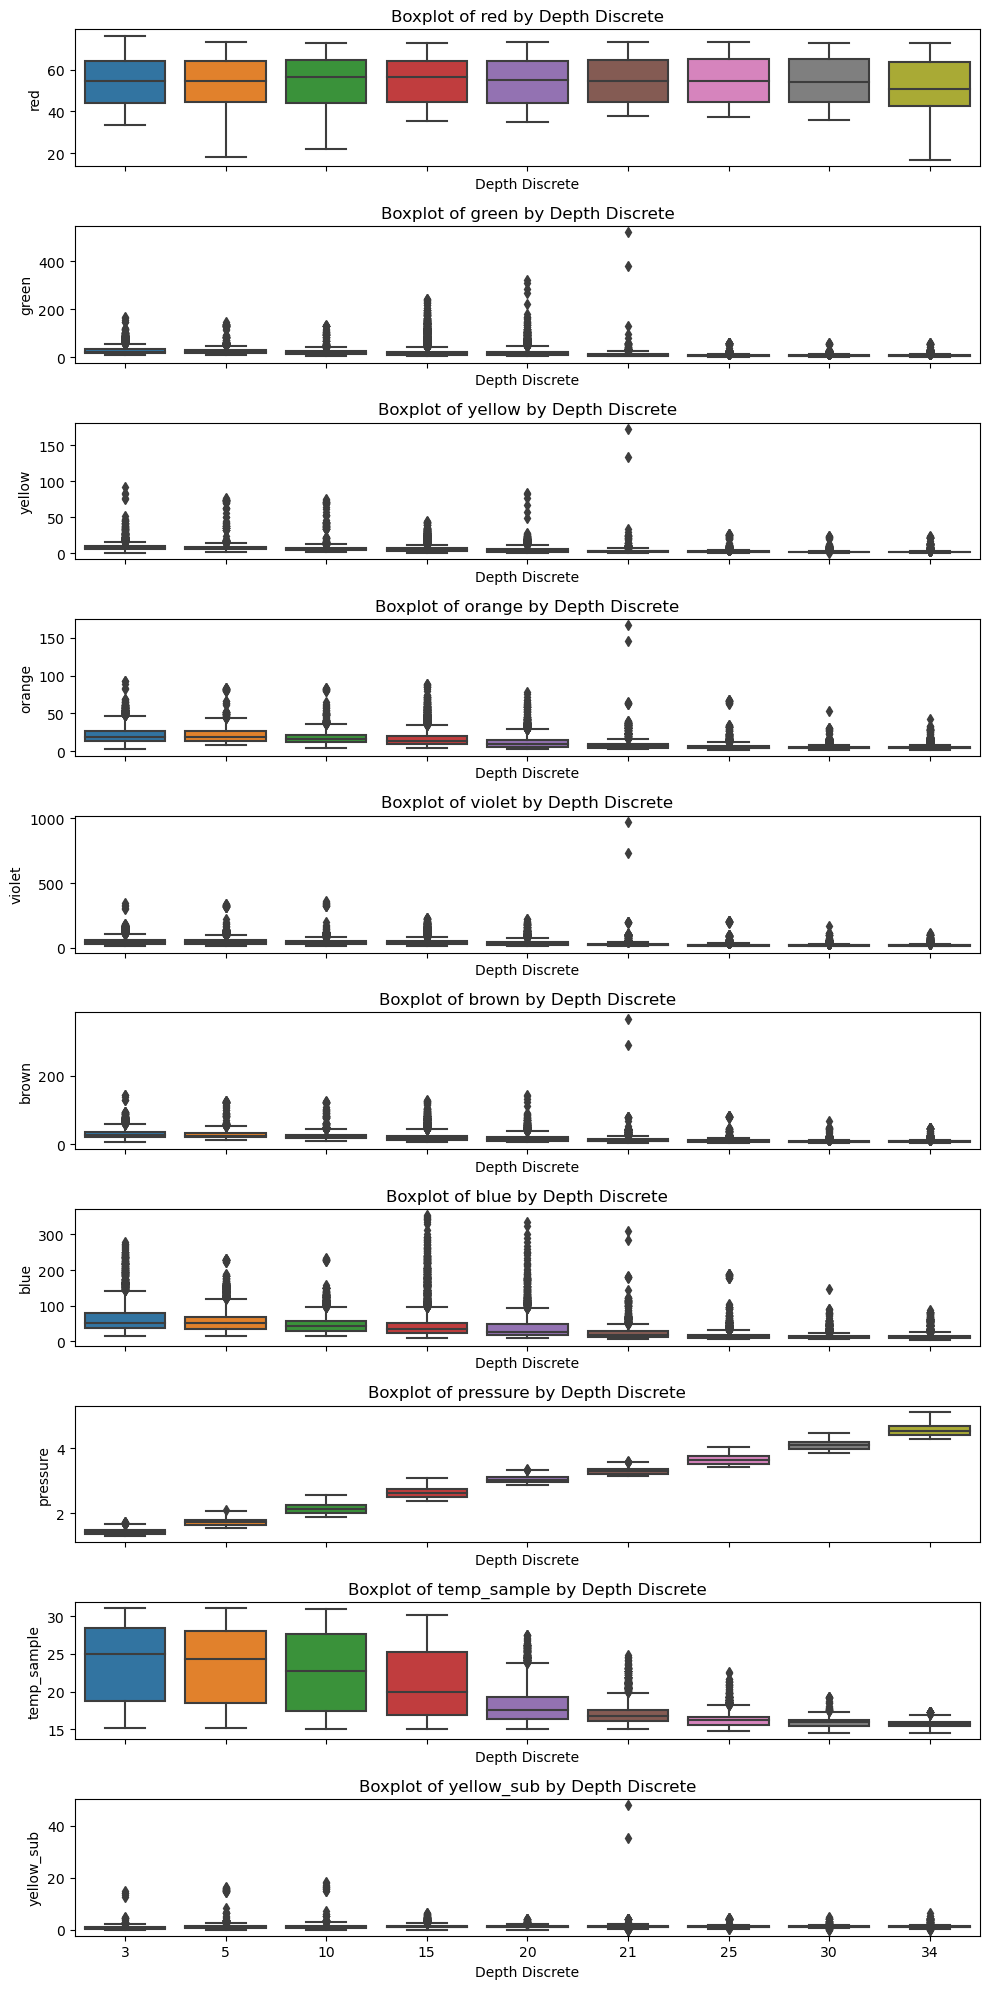

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already loaded and prepared your DataFrame 'fp_df'

# List of signals you want to plot
signals = ['red', 'green', 'yellow', 'orange', 'violet', 'brown', 'blue', 'pressure', 'temp_sample', 'yellow_sub']

# Create subplots
fig, axes = plt.subplots(nrows=len(signals), ncols=1, figsize=(10, 20), sharex=True)

# Loop through each signal and create a boxplot
for idx, signal in enumerate(signals):
    ax = axes[idx]
    sns.boxplot(x='depth_discrete', y=signal, data=fp_df, ax=ax)
    ax.set_ylabel(signal)
    ax.set_xlabel('Depth Discrete')
    ax.set_title(f'Boxplot of {signal} by Depth Discrete')

plt.tight_layout()
plt.show()

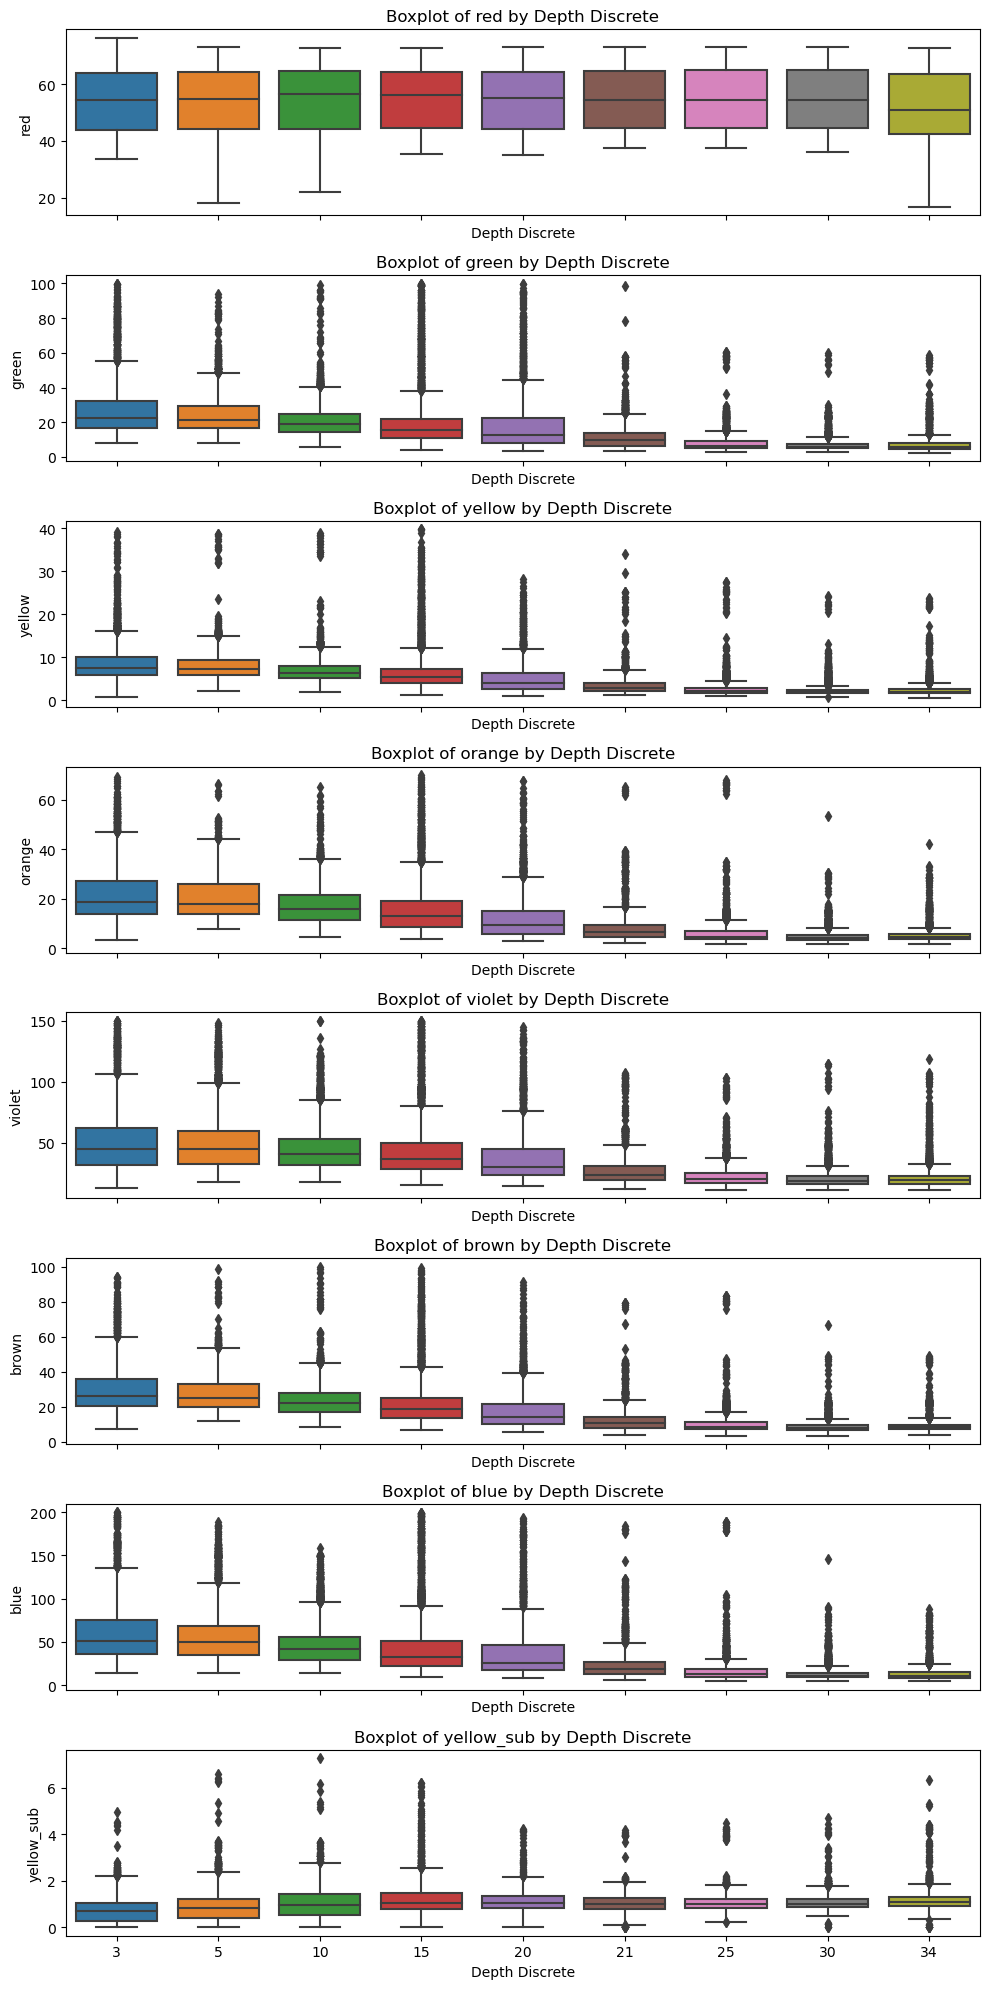

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already loaded and prepared your DataFrame 'fp_df'

# List of signals you want to plot
signals = ['red', 'green', 'yellow', 'orange', 'violet', 'brown', 'blue', 'yellow_sub']
# Dictionary to store records to be removed for each signal
records_to_remove = {signal: [] for signal in signals}

# Create subplots
fig, axes = plt.subplots(nrows=len(signals), ncols=1, figsize=(10, 20), sharex=True)

boundaries = {
    'red': {'lower_bound': 0, 'upper_bound': 100},
    'green': {'lower_bound': 0, 'upper_bound': 100},
    'yellow': {'lower_bound': 0, 'upper_bound': 40},
    'orange': {'lower_bound': 0, 'upper_bound': 70},
    'violet': {'lower_bound': 0, 'upper_bound': 150},
    'brown': {'lower_bound': 0, 'upper_bound': 100},
    'blue': {'lower_bound': 0, 'upper_bound': 200},
    'yellow_sub': {'lower_bound': 0, 'upper_bound': 8}

}
# Loop through each signal and create a boxplot
for idx, signal in enumerate(signals):
    ax = axes[idx]
    
    # Calculate IQR
#     q1 = fp_df[signal].quantile(0.25)
#     q3 = fp_df[signal].quantile(0.75)
#     iqr = q3 - q1
    
    # Define upper and lower bounds to filter out outliers
#     lower_bound = q1 - 1.5 * iqr
#     upper_bound = q3 + 1.5 * iqr
    lower_bound = boundaries[signal]['lower_bound']
    upper_bound = boundaries[signal]['upper_bound']
    
    # Filter the DataFrame
    filtered_df = fp_df[(fp_df[signal] >= lower_bound) & (fp_df[signal] <= upper_bound)]
    
    # Identify records to be removed
    outliers = fp_df[(fp_df[signal] < lower_bound) | (fp_df[signal] > upper_bound)]
    
    # Accumulate records to be removed
    records_to_remove[signal].extend(outliers.index.tolist())
    
    # Create the boxplot with the filtered data
    sns.boxplot(x='depth_discrete', y=signal, data=filtered_df, ax=ax)
    ax.set_ylabel(signal)
    ax.set_xlabel('Depth Discrete')
    ax.set_title(f'Boxplot of {signal} by Depth Discrete')

plt.tight_layout()
plt.show()


In [8]:
# Flatten the list of indices to remove
indices_to_remove = set(idx for lst in records_to_remove.values() for idx in lst)

# Remove accumulated records from 'fp_df'
filtered_df = fp_df.drop(index=indices_to_remove)
filtered_df

depth    red  green  yellow  orange  violet  brown   blue  pressure  \
18      1.53  62.74  21.95    6.85   17.53   48.68  24.67  49.79      1.30   
19      1.60  62.66  21.76    7.25   17.09   47.80  24.32  49.24      1.31   
20      1.71  62.43  21.45    7.45   17.27   48.64  24.72  50.14      1.32   
21      1.81  62.61  21.89    7.23   17.14   48.78  24.13  50.87      1.33   
22      1.95  62.65  21.80    7.37   17.84   48.13  24.91  49.41      1.34   
...      ...    ...    ...     ...     ...     ...    ...    ...       ...   
45189  36.56  41.90   6.95    2.75    5.40   20.68   9.50  11.33      4.73   
45190  37.02  42.14   6.86    2.45    5.18   20.54   9.27  10.87      4.78   
45191  37.43  41.99   7.12    2.60    5.49   21.09   9.59  11.70      4.82   
45192  37.69  42.01   7.03    2.67    5.22   20.78   9.58  11.20      4.85   
45193  38.10  42.05   7.05    2.67    5.12   20.70   9.58  11.07      4.89   

       temp_sample  yellow_sub  Green Algae  Bluegreen  Diatoms  Cryptophyta  \
18           19.93        1.20         9.74       0.29     1.63         5.95   
19           19.93        1.16         9.80       0.02     1.16         6.36   
20           19.93        1.16        10.77       0.00     0.63         6.45   
21           19.93        1.13        10.46       0.00     1.53         6.00   
22           19.93        1.16         9.92       0.27     1.16         6.29   
...            ...         ...          ...        ...      ...          ...   
45189        15.64        1.14         0.00       0.40     0.63         0.52   
45190        15.62        1.14         0.00       0.39     0.55         0.49   
45191        15.59        1.15         0.00       0.43     0.78         0.43   
45192        15.59        1.15         0.00       0.35     0.47         0.65   
45193        15.59        1.14         0.00       0.32     0.38         0.73   

       Total conc  week  year  month  depth_discrete  
18          17.62    49  2019     12               3  
19          17.33    49  2019     12               3  
20          17.84    49  2019     12               3  
21          17.99    49  2019     12               3  
22          17.64    49  2019     12               3  
...           ...   ...   ...    ...             ...  
45189        1.55    27  2022      7              34  
45190        1.43    27  2022      7              34  
45191        1.64    27  2022      7              34  
45192        1.48    27  2022      7              34  
45193        1.43    27  2022      7              34  

[38831 rows x 20 columns]

In [9]:
filtered_df.drop('depth_discrete', axis=1, inplace=True)

## Splitting to test temporarily & Extracting probe's test data

In [10]:
biomass_test = biomass_by_week_year_group[(biomass_by_week_year_group['year'] == 2022) & (biomass_by_week_year_group['month'] >= 3)]
biomass_train = biomass_by_week_year_group[~biomass_by_week_year_group.index.isin(biomass_test.index)]

fp_test = filtered_df[(filtered_df['year'] == 2022) & (filtered_df['month'] >= 3)]
fp_train = filtered_df[~filtered_df.index.isin(fp_test.index)]

merged_train = merge_fp_biomass_df(fp_train, biomass_train, is_train=True) # Merging fully
merged_test = merge_fp_biomass_df(fp_test, biomass_test, is_train=False) # Merging only closest records by depth

In [11]:
# merged_df_test = merged_df[(merged_df['year'] == 2022) & (merged_df['month'] >= 4)]
# merged_df = merged_df[~merged_df.index.isin(merged_df_test.index)]

# orig_merged_df = merged_df.copy()

# merged_df = merged_df.drop(['week'], axis=1)
# merged_df_test = merged_df_test.drop(['week'], axis=1)

In [12]:
merged_train = merged_train.drop(['Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta'], axis=1).reset_index(drop=True)

fluor_groups_map = {
    2: 'Bluegreen',
    3: 'Diatoms',
    4: 'Green Algae',
    6: 'Cryptophyta'
}

fluor_test_df = merged_test[['group_num', 'month', 'Depth', 'sum_biomass_ug_ml', 'Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta']].reset_index(drop=True)
merged_test = merged_test.drop(['Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta'], axis=1).reset_index(drop=True)

In [13]:
# merged_df = merge_fp_biomass_df(filtered_df, biomass_by_week_year_group)

In [14]:
prev_depths = {
    3: 0,
    5: 3,
    10: 5,
    15: 10,
    20: 15,
    21: 20,
    25: 21,
    30: 25
}

In [15]:
# Calculate estimated sum_biomass_ug_ml
estimated_biomass = []
current_step = 0  # Initialize the step for the current week-year-month frame
depth_diffs = []

for index, row in merged_train.iterrows():
    # Calculate step for the current week-year-month frame
    next_df = merged_train[(merged_train.week == row.week) & 
                        (merged_train.year == row.year) & 
                        (merged_train.month == row.month) & 
                        (merged_train.group_num == row.group_num) &
                        (merged_train.Depth == prev_depths[row.Depth])]
    if next_df.shape[0] > 0:
        step_numerator = row['sum_biomass_ug_ml'] - next_df.iloc[0]['sum_biomass_ug_ml']
        step_denominator = row['Depth'] - next_df.iloc[0]['Depth']
    else:
        step_numerator = row['sum_biomass_ug_ml']
        step_denominator = row['Depth']

    current_step = step_numerator / step_denominator
        
    depth_diff = row['Depth'] - row['depth']
    depth_diffs.append(depth_diff)
    
    estimated_biomass_value = row['sum_biomass_ug_ml']
    estimated_biomass_value += current_step * depth_diff
    
    estimated_biomass.append(estimated_biomass_value)

merged_train['estimated_sum_biomass_ug_ml'] = estimated_biomass
merged_train['depth_diffs'] = depth_diffs
merged_train

depth    red  green  yellow  orange  violet  brown   blue  pressure  \
0       1.53  62.74  21.95    6.85   17.53   48.68  24.67  49.79      1.30   
1       1.53  62.74  21.95    6.85   17.53   48.68  24.67  49.79      1.30   
2       1.53  62.74  21.95    6.85   17.53   48.68  24.67  49.79      1.30   
3       1.53  62.74  21.95    6.85   17.53   48.68  24.67  49.79      1.30   
4       1.53  62.74  21.95    6.85   17.53   48.68  24.67  49.79      1.30   
...      ...    ...    ...     ...     ...     ...    ...    ...       ...   
55499  17.36  41.64  31.74    7.44   18.85   70.30  25.00  55.71      2.85   
55500  17.36  41.64  31.74    7.44   18.85   70.30  25.00  55.71      2.85   
55501  17.36  41.64  31.74    7.44   18.85   70.30  25.00  55.71      2.85   
55502  17.36  41.64  31.74    7.44   18.85   70.30  25.00  55.71      2.85   
55503  17.36  41.64  31.74    7.44   18.85   70.30  25.00  55.71      2.85   

       temp_sample  yellow_sub  Total conc  week  year  month  Depth  \
0            19.93        1.20       17.62    49  2019     12      3   
1            19.93        1.20       17.62    49  2019     12      3   
2            19.93        1.20       17.62    49  2019     12      3   
3            19.93        1.20       17.62    49  2019     12      3   
4            19.93        1.20       17.62    49  2019     12      3   
...            ...         ...         ...   ...   ...    ...    ...   
55499        25.29        3.07       10.39    31  2021      8     15   
55500        25.29        3.07       10.39    31  2021      8     15   
55501        25.29        3.07       10.39    31  2021      8     15   
55502        25.29        3.07       10.39    31  2021      8     15   
55503        25.29        3.07       10.39    31  2021      8     15   

       group_num  sum_biomass_ug_ml  estimated_sum_biomass_ug_ml  depth_diffs  
0              2           0.691145                     1.029806         1.47  
1              3           0.271380                     0.404356         1.47  
2              4           0.811216                     1.208712         1.47  
3              5           2.854117                     4.252635         1.47  
4              6           0.191077                     0.284704         1.47  
...          ...                ...                          ...          ...  
55499          2           0.542622                     0.800919        -2.36  
55500          3           0.217202                     0.168807        -2.36  
55501          4           0.635706                     0.713698        -2.36  
55502          5           0.079845                     0.058426        -2.36  
55503          6           0.246363                     0.193410        -2.36  

[55504 rows x 20 columns]

In [16]:
merged_train.drop(['sum_biomass_ug_ml', 'depth_diffs'], axis=1, inplace=True)
merged_train.rename(columns={'estimated_sum_biomass_ug_ml': 'sum_biomass_ug_ml'}, inplace=True)

In [17]:
merged_train

depth    red  green  yellow  orange  violet  brown   blue  pressure  \
0       1.53  62.74  21.95    6.85   17.53   48.68  24.67  49.79      1.30   
1       1.53  62.74  21.95    6.85   17.53   48.68  24.67  49.79      1.30   
2       1.53  62.74  21.95    6.85   17.53   48.68  24.67  49.79      1.30   
3       1.53  62.74  21.95    6.85   17.53   48.68  24.67  49.79      1.30   
4       1.53  62.74  21.95    6.85   17.53   48.68  24.67  49.79      1.30   
...      ...    ...    ...     ...     ...     ...    ...    ...       ...   
55499  17.36  41.64  31.74    7.44   18.85   70.30  25.00  55.71      2.85   
55500  17.36  41.64  31.74    7.44   18.85   70.30  25.00  55.71      2.85   
55501  17.36  41.64  31.74    7.44   18.85   70.30  25.00  55.71      2.85   
55502  17.36  41.64  31.74    7.44   18.85   70.30  25.00  55.71      2.85   
55503  17.36  41.64  31.74    7.44   18.85   70.30  25.00  55.71      2.85   

       temp_sample  yellow_sub  Total conc  week  year  month  Depth  \
0            19.93        1.20       17.62    49  2019     12      3   
1            19.93        1.20       17.62    49  2019     12      3   
2            19.93        1.20       17.62    49  2019     12      3   
3            19.93        1.20       17.62    49  2019     12      3   
4            19.93        1.20       17.62    49  2019     12      3   
...            ...         ...         ...   ...   ...    ...    ...   
55499        25.29        3.07       10.39    31  2021      8     15   
55500        25.29        3.07       10.39    31  2021      8     15   
55501        25.29        3.07       10.39    31  2021      8     15   
55502        25.29        3.07       10.39    31  2021      8     15   
55503        25.29        3.07       10.39    31  2021      8     15   

       group_num  sum_biomass_ug_ml  
0              2           1.029806  
1              3           0.404356  
2              4           1.208712  
3              5           4.252635  
4              6           0.284704  
...          ...                ...  
55499          2           0.800919  
55500          3           0.168807  
55501          4           0.713698  
55502          5           0.058426  
55503          6           0.193410  

[55504 rows x 18 columns]

# Plot

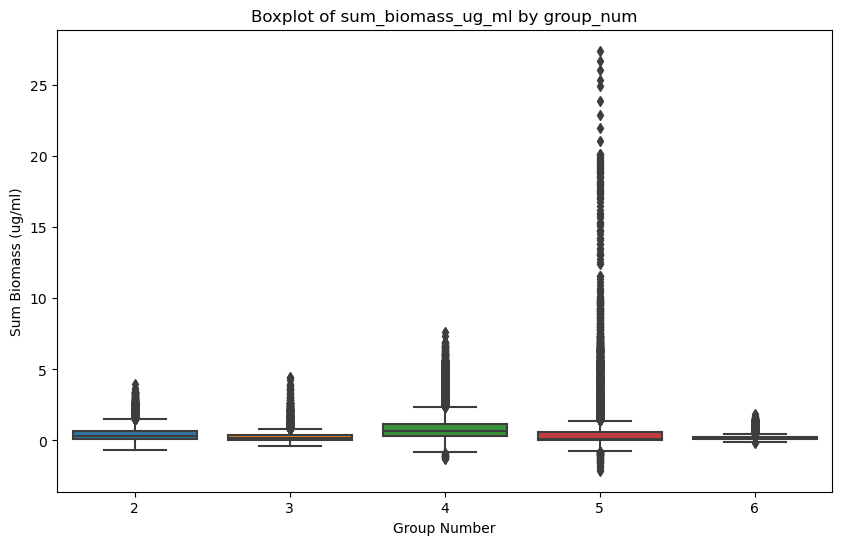

In [18]:
boxplot(merged_train)

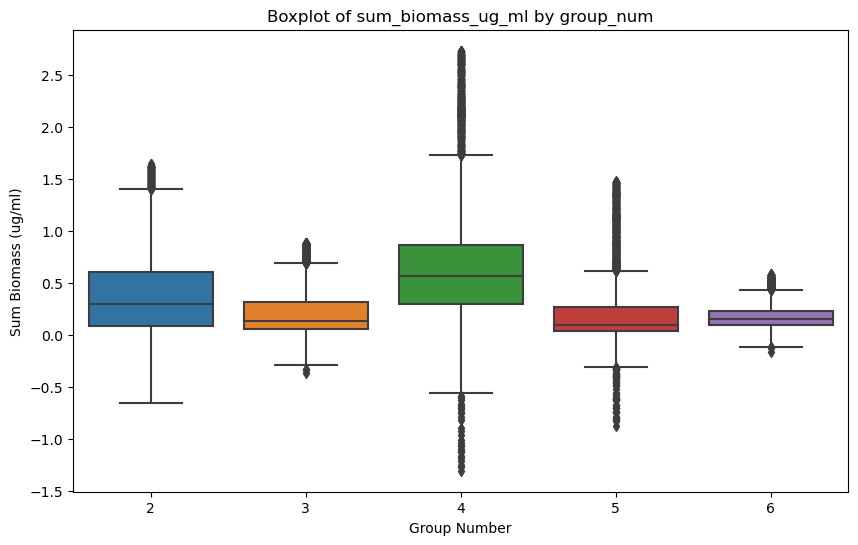

In [19]:
filtered_df = remove_outliers_IQR(merged_train, q1=0.05, q3=0.75)
boxplot(filtered_df)

In [20]:
merged_train = filtered_df

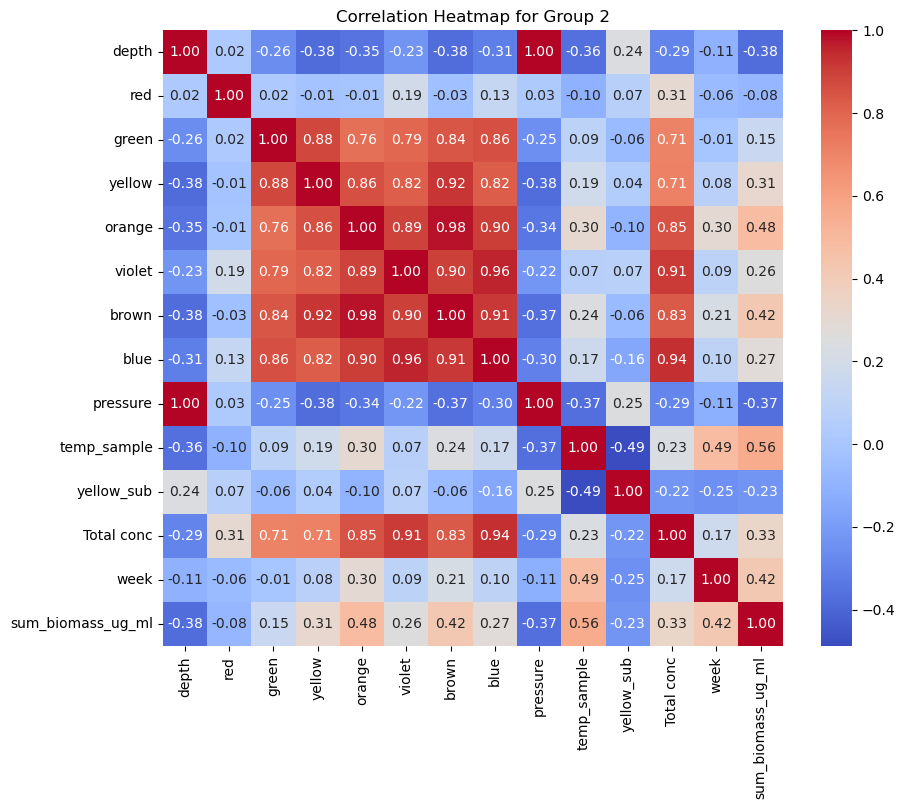

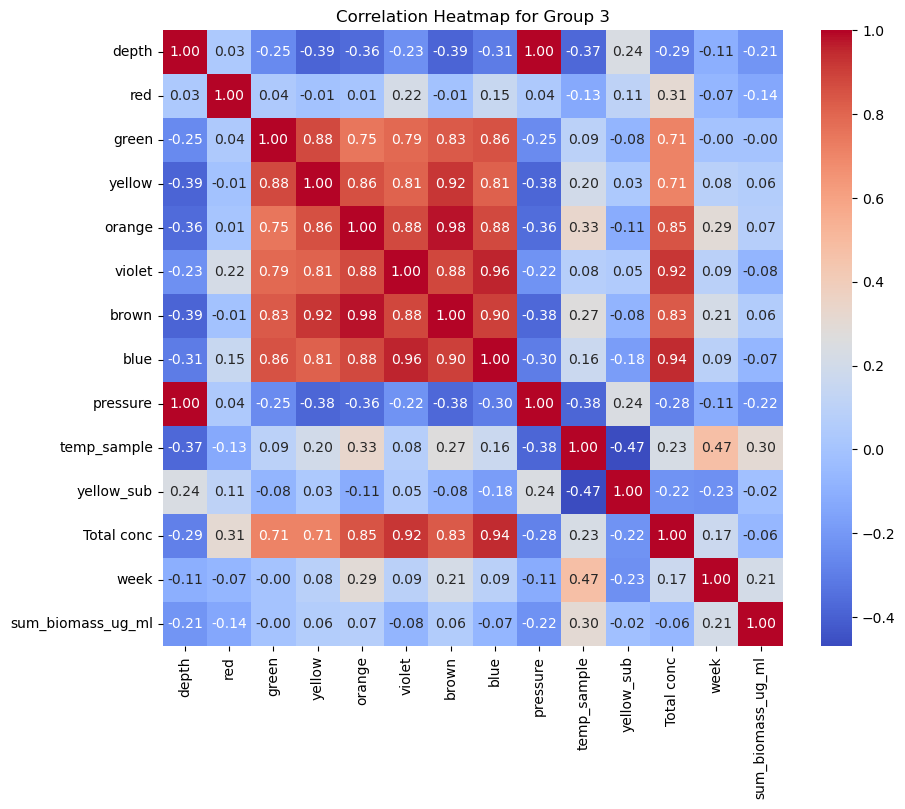

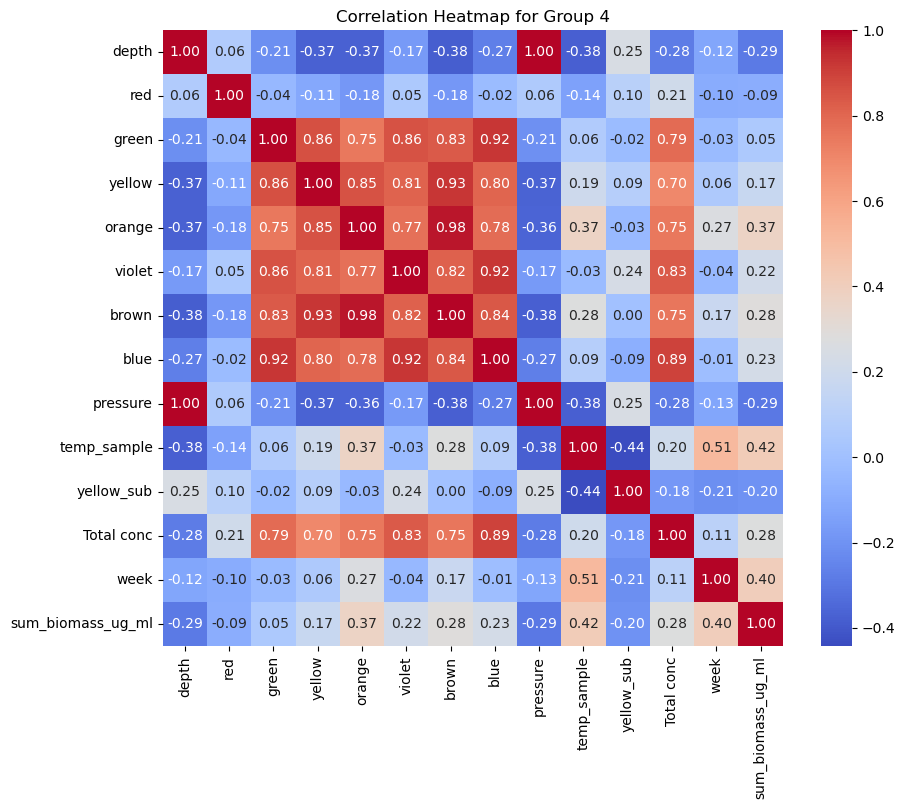

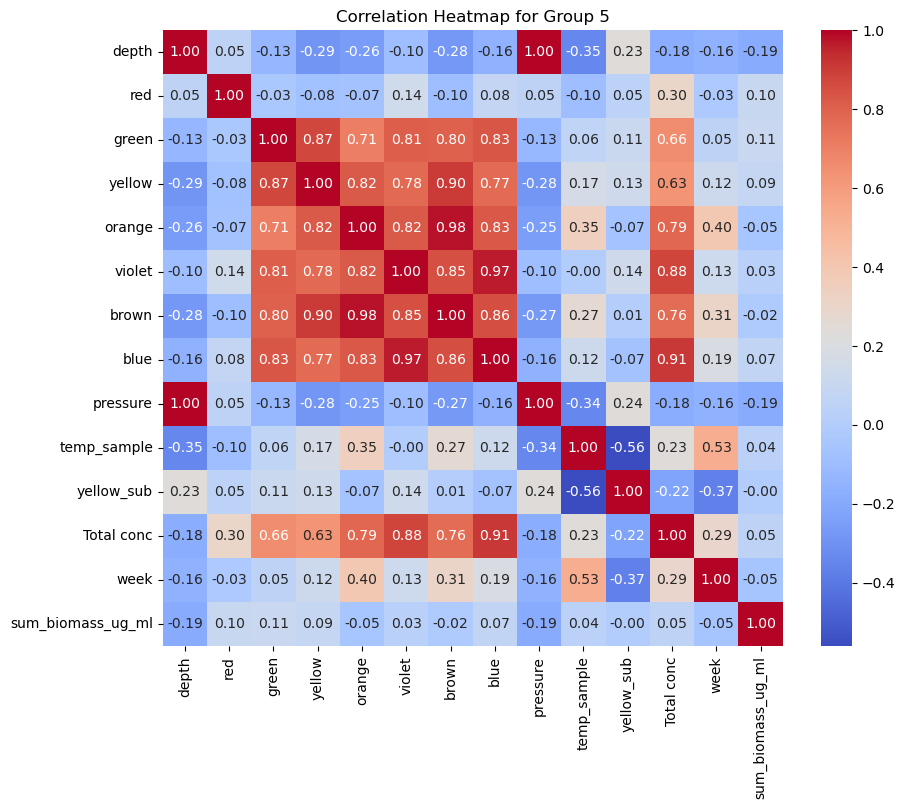

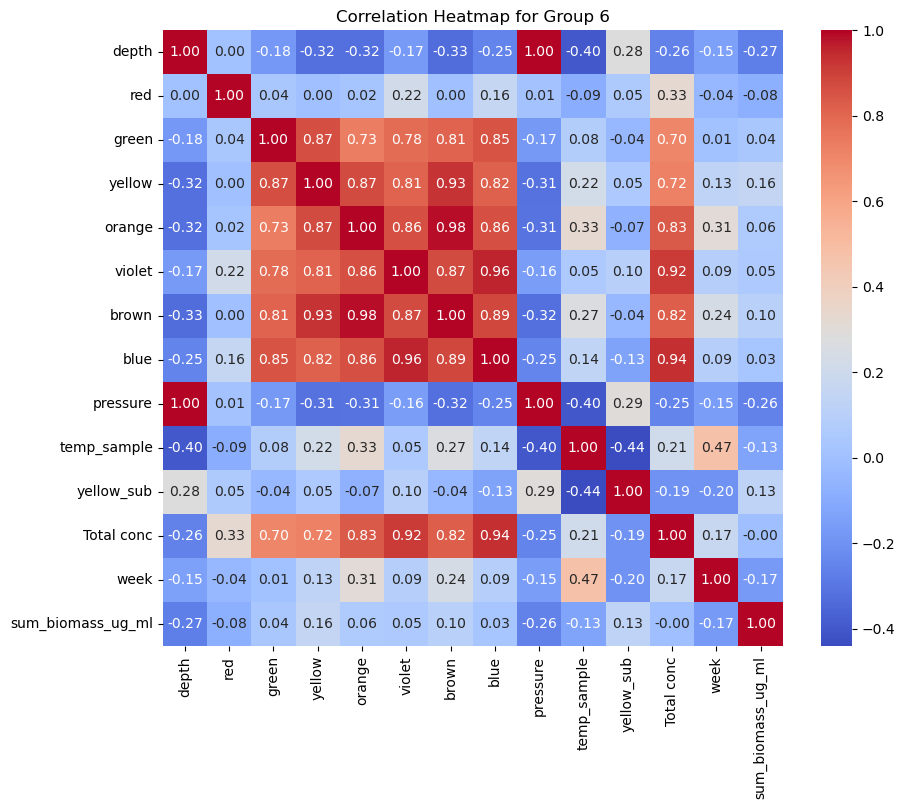

In [21]:
correlation_per_group(merged_train)

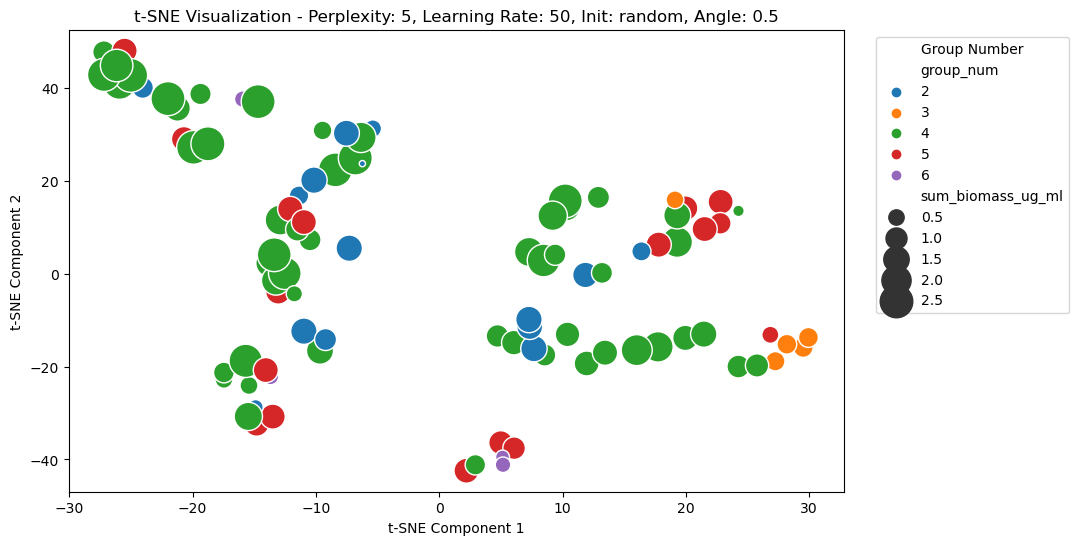

In [22]:
plot_tsne(merged_train)

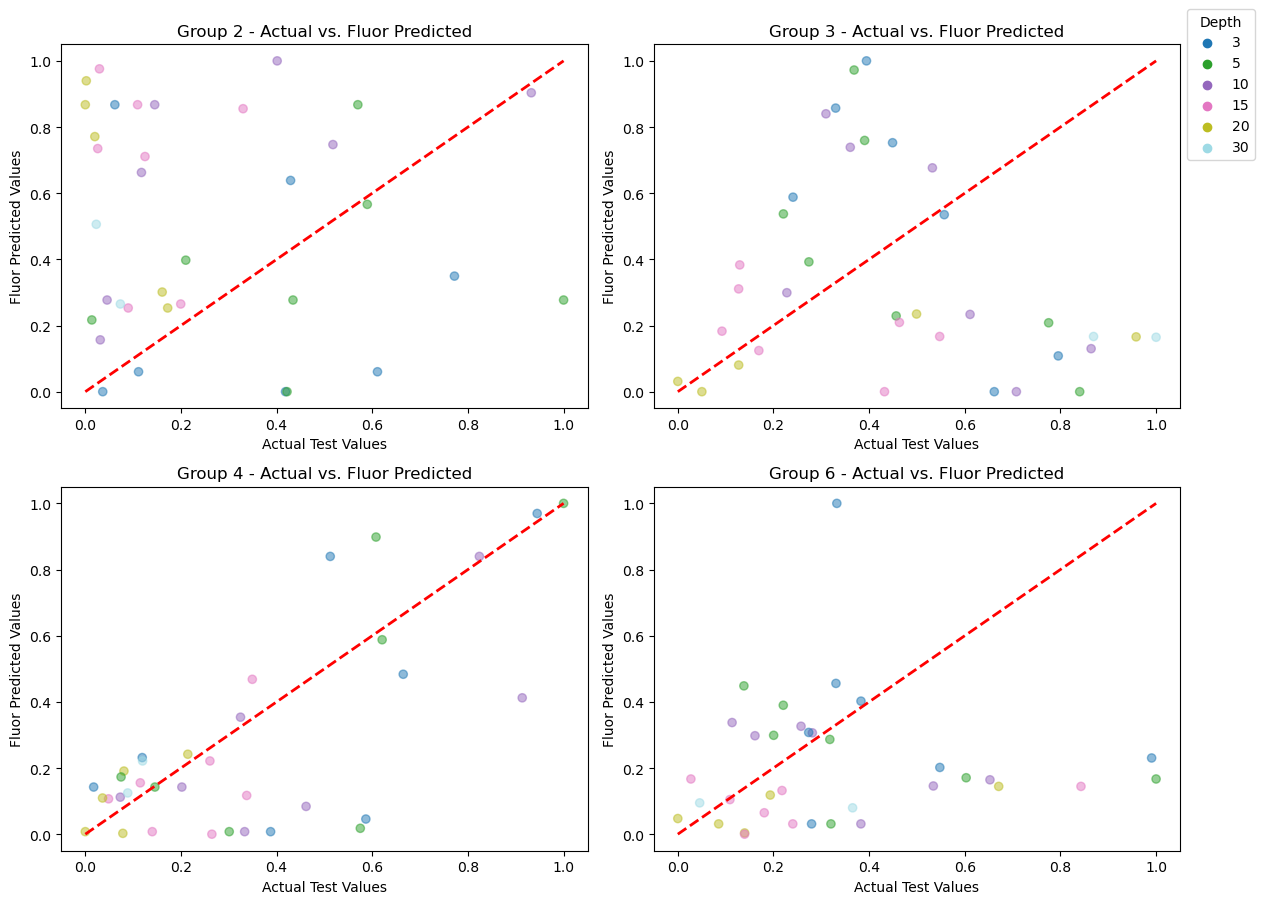

In [23]:
plot_fluorprobe_prediction(fluor_test_df, fluor_groups_map)

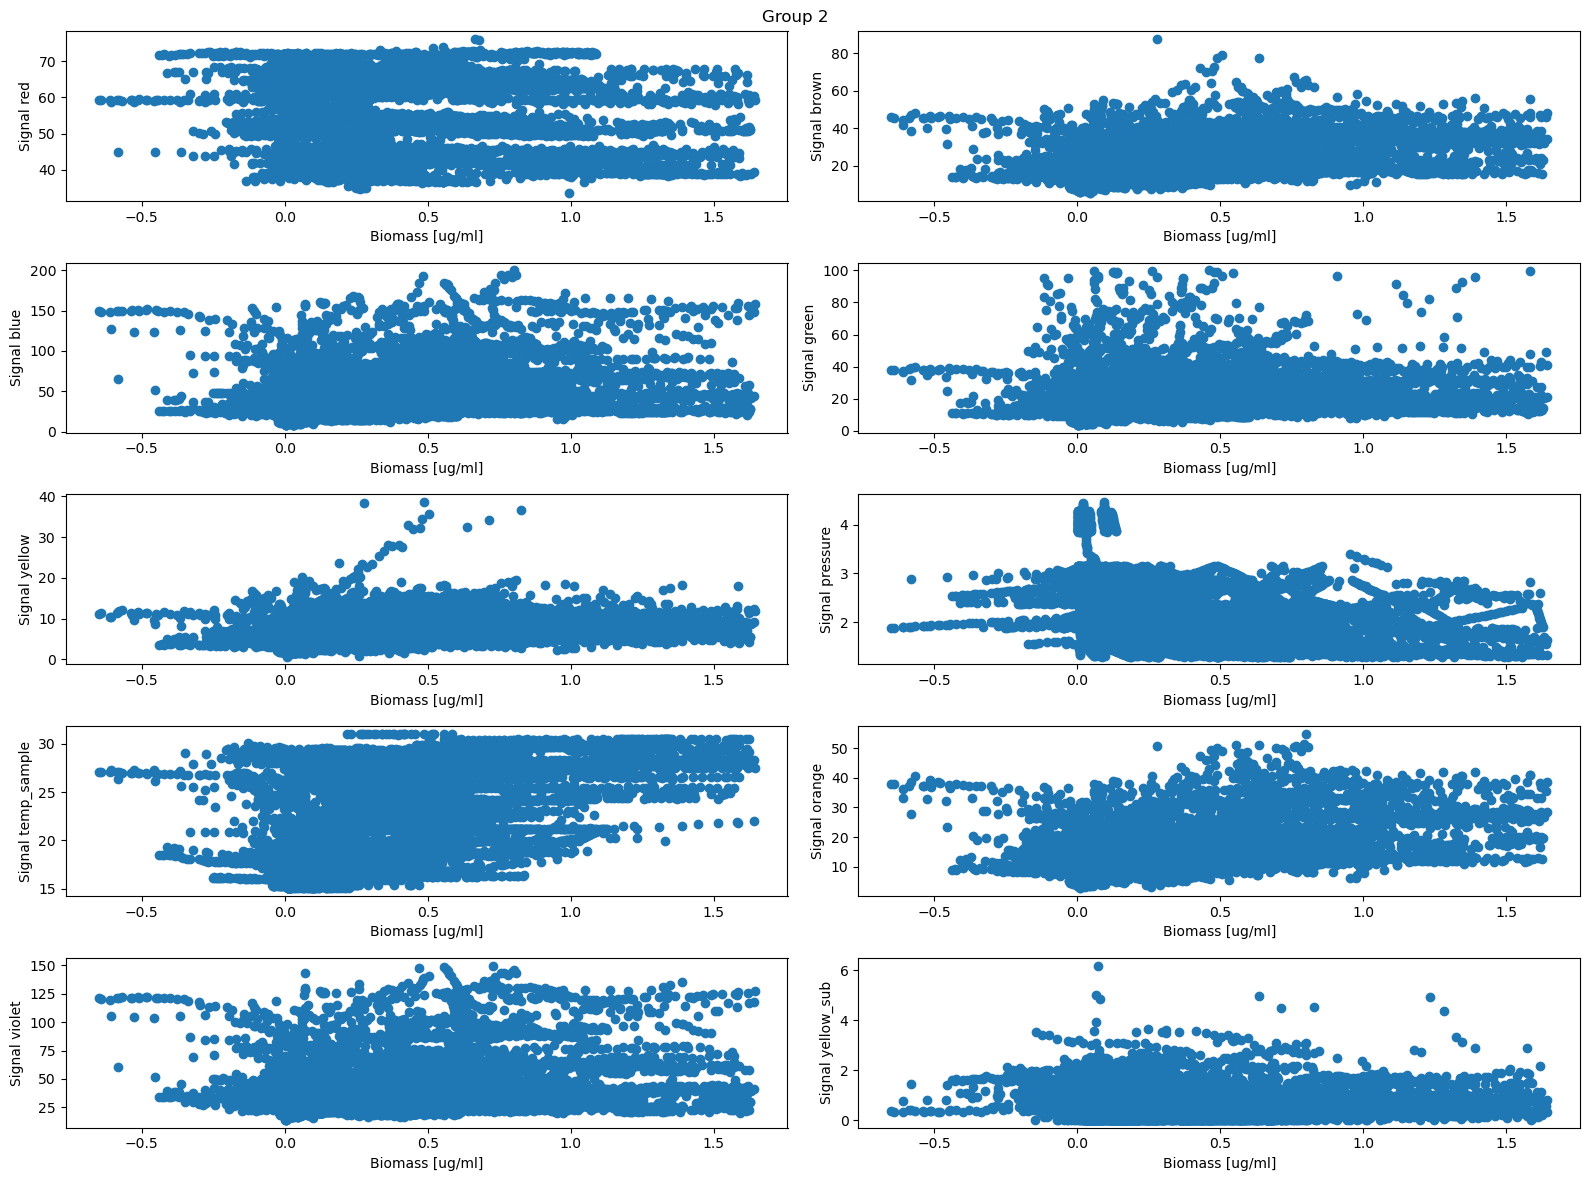

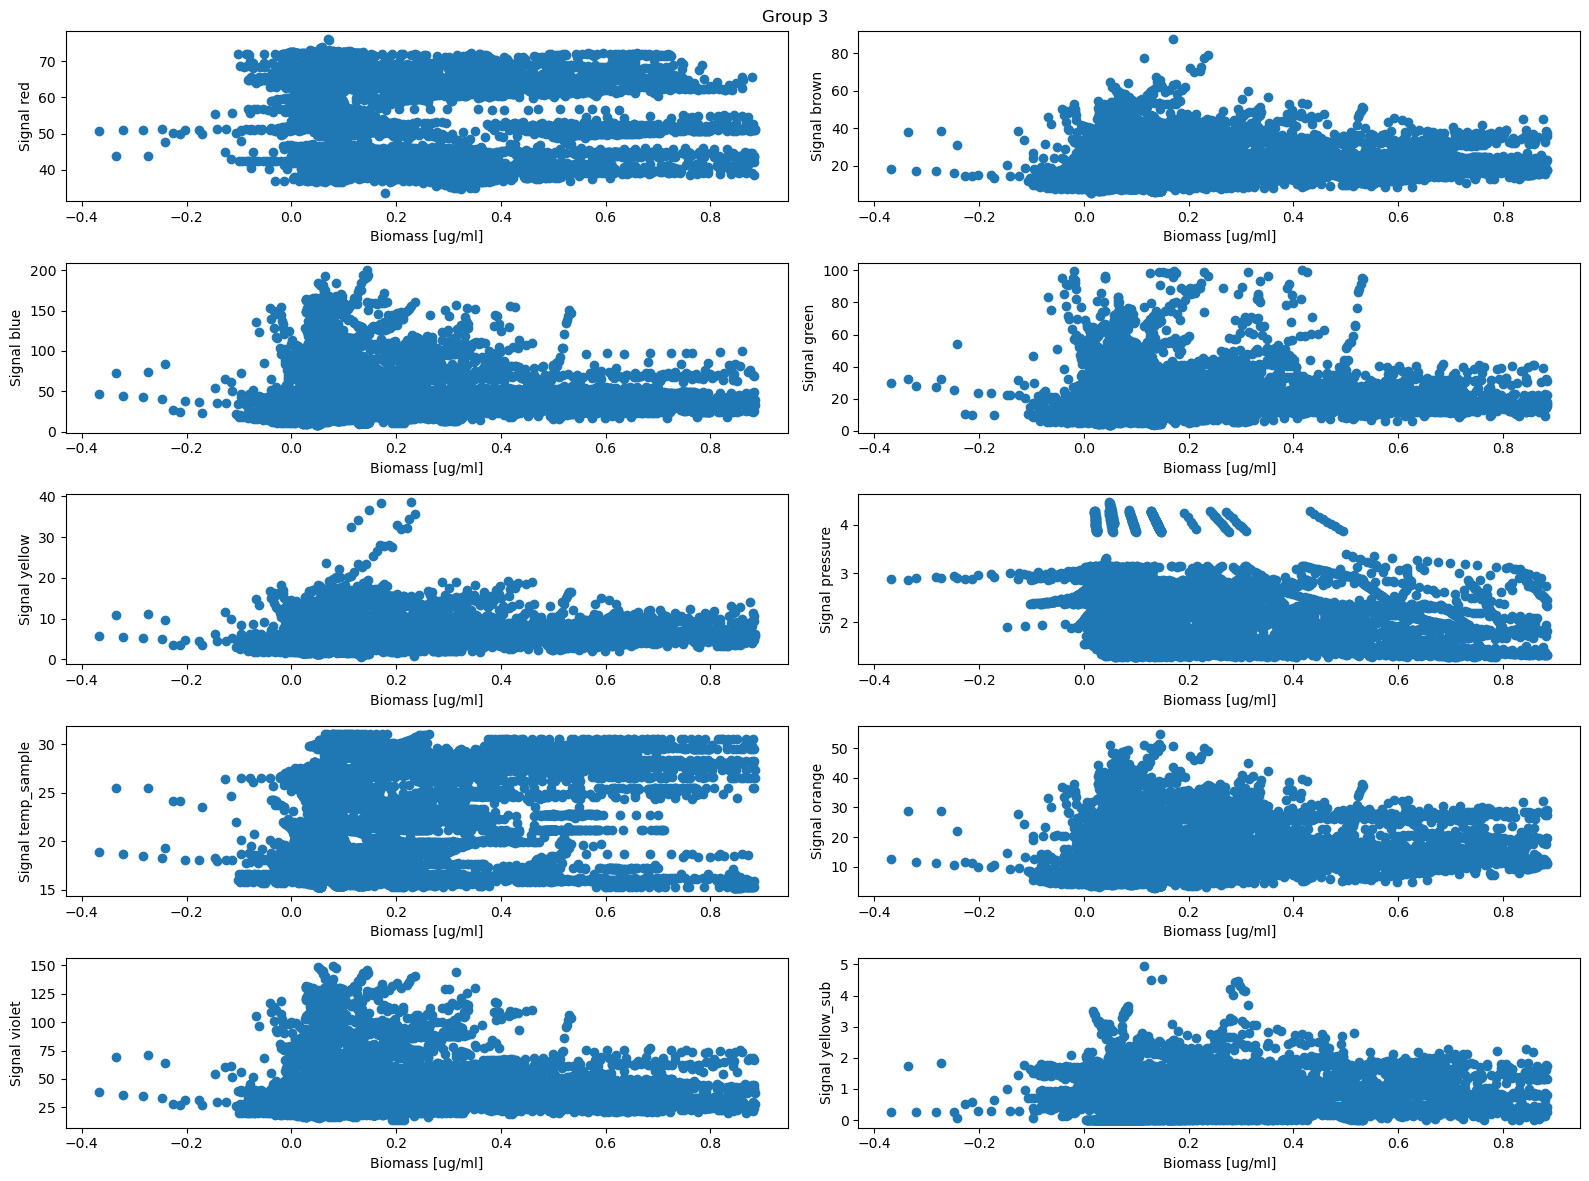

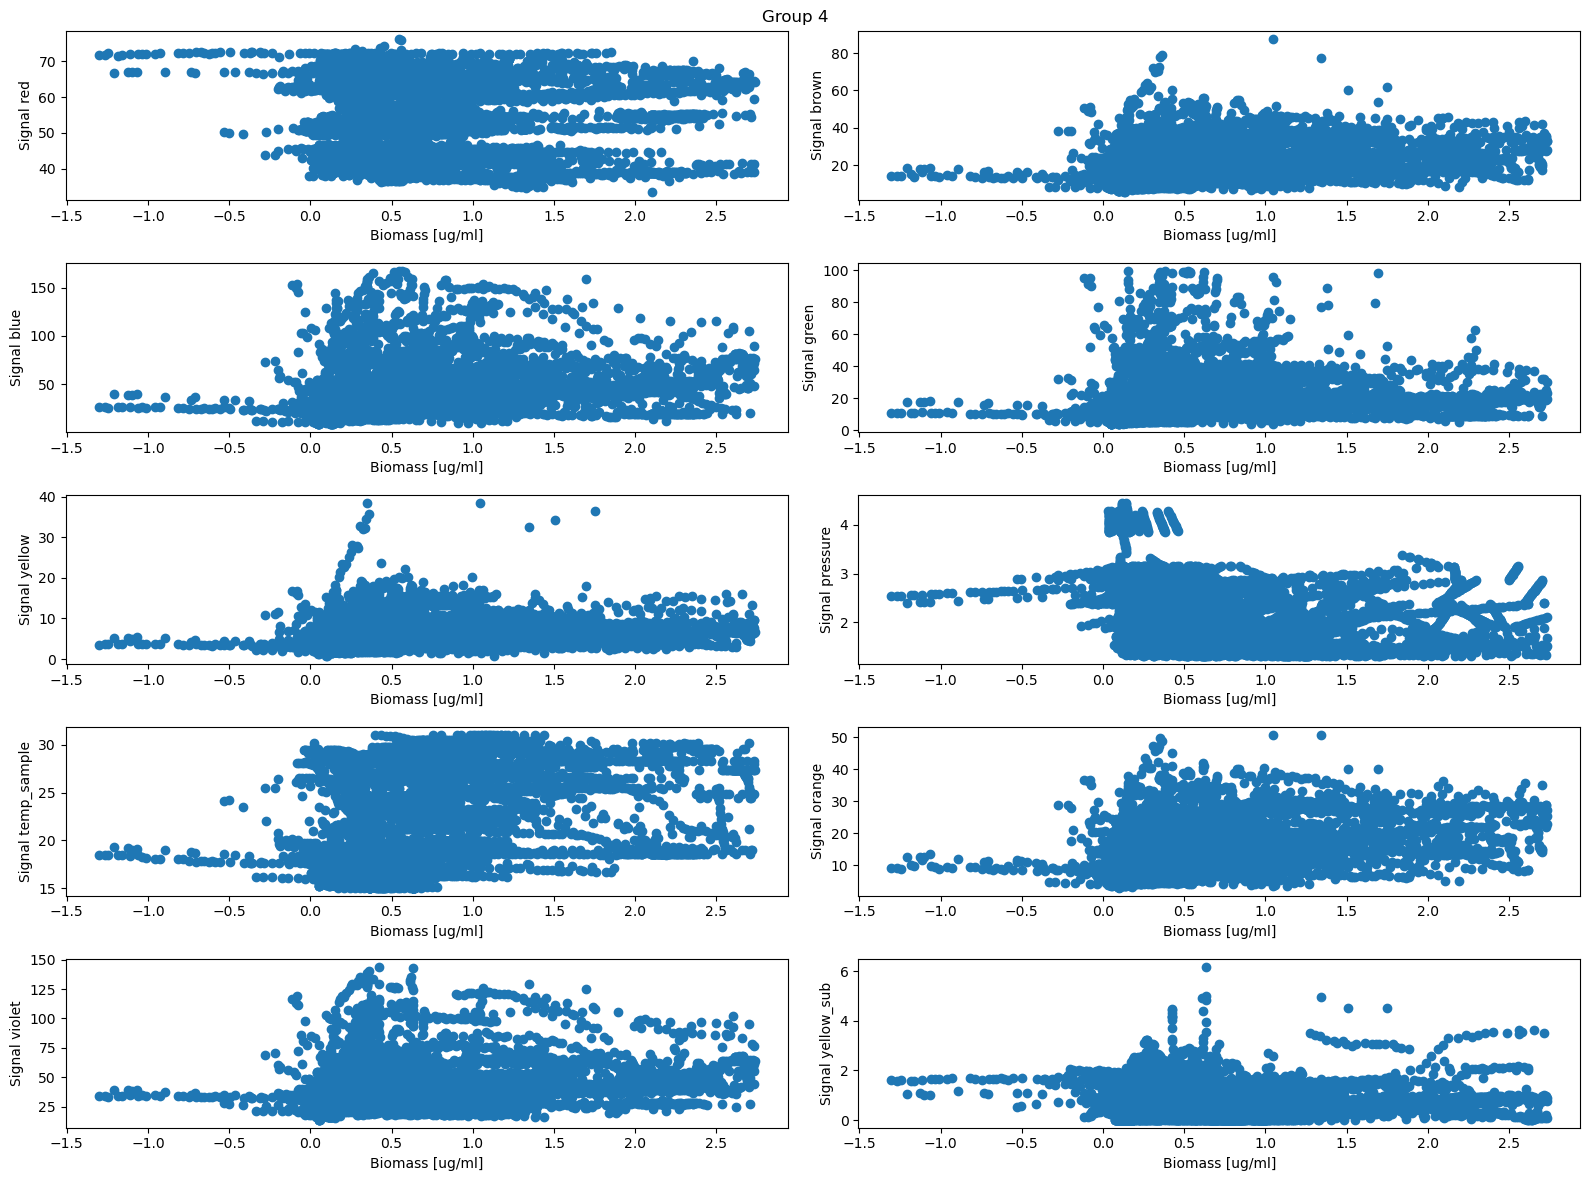

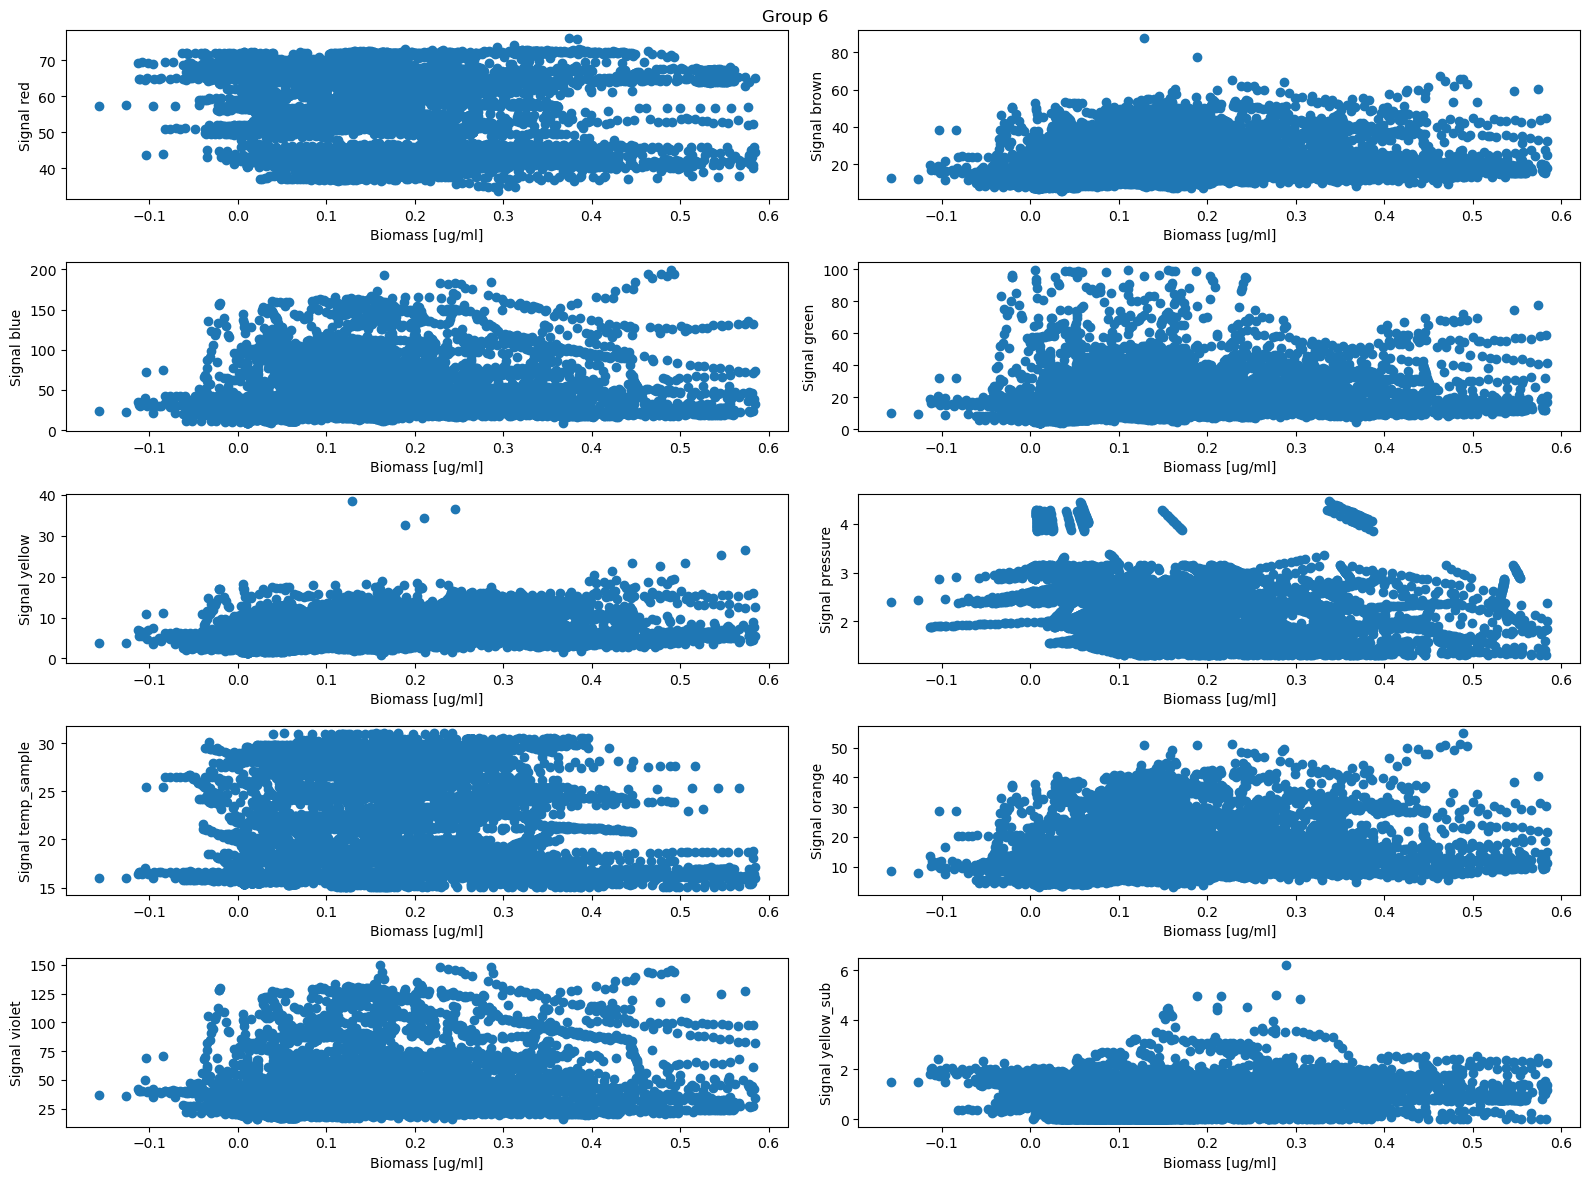

In [24]:
plot_corr_per_feature_per_group(merged_train, fluor_groups_map)

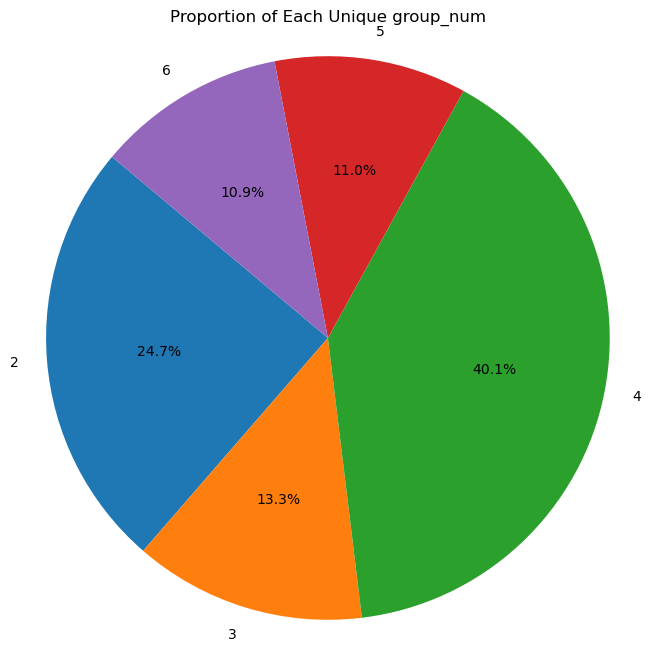

In [25]:
groups_pie_chart(merged_train, by_biomass=True)

In [26]:
merged_train = merged_train.drop(['year', 'Depth', 'depth', 'week'], axis=1)
merged_test = merged_test.drop(['year', 'Depth', 'week'], axis=1)
fluor_test_df = fluor_test_df.drop('Depth', axis=1)

# Training models and evaluating

## Grid Search per model

In [30]:
pickled_params = 'best_grid_params.pkl'
do_search = not os.path.exists(pickled_params)

In [38]:
def two_scorer(mse=False):
    score = mean_squared_error if mse else r2_score
    return make_scorer(score, greater_is_better=mse==False)

In [40]:
if do_search:
#     param_grid_per_model = {'xgb': {
#         "model__n_estimators": [100, 300, 500], # Number of boosting rounds
#         "model__learning_rate": [0.01, 0.1, 0.2], # Step size shrinkage
#         "model__max_depth": [3, 5, 7, 11], # Maximum depth of a tree,
#         'model__min_child_weight': [1, 5, 7],  # Minimum sum of instance weight needed in a child
#         "model__subsample": [0.2, 0.5, 1.0], # Fraction of samples used for fitting trees
#         "model__colsample_bytree": [0.2, 0.8, 1.0] # Fraction of features used for fitting trees
#     },
#     'svr':  {
#         "model__C": [0.1, 1, 10, 100], # Regularization parameter
#         "model__kernel": ["poly", "rbf"],
#         "model__degree": [1, 2, 3], # Degree of the polynomial kernel (for "poly" kernel)
#         "model__epsilon": [0.01, 0.1, 0.2], # Epsilon in the epsilon-SVR loss function
#         "model__tol": [1e-4, 1e-3, 1e-2] # Tolerance for stopping criterion
#     },
#     'elf': {
#         "model__alpha": [0.01, 0.1, 1, 10], # Regularization parameter
#         "model__l1_ratio": [0.2, 0.5, 0.8], # Mixing parameter between L1 and L2 regularization
#         "model__fit_intercept": [True, False], # Whether to calculate the intercept for the model
#     }}
    param_grid_per_model = {'xgb': {
        "model__n_estimators": [100, 300, 500], # Number of boosting rounds
        "model__max_depth": [2, 3, 5], # Maximum depth of a tree,
        "model__learning_rate": [0.01, 0.1, 0.2], # Step size shrinkage
        "model__alpha": [0.01, 0.1, 1, 10], # L1 regularization term
        "model__l1_ratio": [0.2, 0.5, 0.8], # Mixing parameter between L1 and L2 regularization
    },
    'svr':  {
        "model__C": [0.001, 0.1, 1, 10, 100], # Regularization parameter
        "model__epsilon": [0.01, 0.1, 0.2], # Epsilon in the epsilon-SVR loss function
        "model__tol": [1e-4, 1e-3, 1e-2] # Tolerance for stopping criterion
    },
    'elf': {
        "model__alpha": [0.01, 0.1, 1, 10], # Regularization parameter
        "model__l1_ratio": [0.2, 0.5, 0.8], # Mixing parameter between L1 and L2 regularization
    }}
    
    best_group_params_per_model = {}
    for model_name, param_grid in param_grid_per_model.items():
        best_group_params_per_model[model_name] = grid_search_cv(model_name, merged_train, param_grid=param_grid,
                                                                scoring_method=two_scorer(mse=False))
    
    with open(pickled_params, 'wb') as f:
        pickle.dump(best_group_params_per_model, f)
    
    best_group_params_per_model_fixed = {}
    for model_name, kwargs_per_group in best_group_params_per_model.items():
        best_group_params_per_model_fixed[model_name] = {}
        for group_num in kwargs_per_group.keys():
            best_group_params_per_model_fixed[model_name][group_num] = {}
            kwargs = kwargs_per_group[group_num]
            for param, val in kwargs.items():
                fixed_param = param.split('model__')[1]
                best_group_params_per_model_fixed[model_name][group_num][fixed_param] = val


    with open(pickled_params, 'wb') as f:
        pickle.dump(best_group_params_per_model_fixed, f)

else:
    with open(pickled_params, 'rb') as f:
        best_group_params_per_model_fixed = pickle.load(f)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV 2/5; 1/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100
[23:14:26] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 1/324] END model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100;, score=0.367 total time=   0.5s
[CV 5/5; 1/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100
[23:14:27] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 1/324] END model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100;, score=0.388 total time=   0.5s
[CV 4/5; 2/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.01, model__

[CV 1/5; 1/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100
[23:14:27] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 1/324] END model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100;, score=0.386 total time=   0.5s
[CV 1/5; 2/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=300
[23:14:27] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 2/324] END model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=300;, score=0.589 total time=   1.6s
[CV 5/5; 2/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=300
[23:14:29] WARNING: /croot/

[23:15:08] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 14/324] END model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300;, score=0.820 total time=   2.7s
[CV 1/5; 15/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=500
[23:15:10] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 15/324] END model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=500;, score=0.871 total time=   4.4s
[CV 5/5; 15/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=500
[23:15:15] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 15/324] END model__alpha=0.0

[23:15:10] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 15/324] END model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=500;, score=0.848 total time=   4.3s
[CV 1/5; 16/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100
[23:15:15] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 16/324] END model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100;, score=0.884 total time=   1.6s
[CV 3/5; 16/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100
[23:15:16] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 16/324] END model__alpha=0.0

[CV 3/5; 29/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=300;, score=0.576 total time=   2.3s
[CV 1/5; 30/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500
[23:16:12] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 30/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500;, score=0.637 total time=   3.1s
[CV 5/5; 30/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500
[23:16:15] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 30/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500;, score=0.637 total time

[CV 3/5; 35/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=300;, score=0.784 total time=   5.4s
[CV 2/5; 36/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=500
[23:16:35] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 36/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=500;, score=0.816 total time=   8.1s
[CV 1/5; 37/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=100
[23:16:43] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 37/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=100;, score=0.687 total time= 

[CV 5/5; 44/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300
[23:17:09] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 44/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300;, score=0.933 total time=   4.6s
[CV 4/5; 45/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500
[23:17:13] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 45/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500;, score=0.927 total time=   7.6s
[CV 5/5; 47/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=300
[23:17:21] WARNING: /croot/

[CV 2/5; 48/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=500
[23:17:22] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 48/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=500;, score=0.794 total time=   2.9s
[CV 1/5; 49/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100
[23:17:25] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 49/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100;, score=0.829 total time=   0.9s
[CV 3/5; 49/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100
[23:17:26] WARNING: /croot/

[23:18:01] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 59/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300;, score=0.673 total time=   2.7s
[CV 3/5; 60/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500
[23:18:04] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 60/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500;, score=0.690 total time=   4.4s
[CV 2/5; 61/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100
[23:18:08] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 61/324] END model__alpha

[23:18:34] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 67/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=0.740 total time=   0.9s
[CV 4/5; 67/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100
[23:18:35] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 67/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=0.768 total time=   0.9s
[CV 2/5; 68/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300
[23:18:36] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 68/324] END model__alpha=0.0

[CV 3/5; 75/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=500;, score=0.807 total time=   2.9s
[CV 2/5; 76/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100
[23:19:07] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 76/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100;, score=0.797 total time=   0.9s
[CV 4/5; 76/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100
[23:19:08] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 76/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100;, score=0.818 total time=   0

[CV 1/5; 80/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300;, score=0.929 total time=   4.5s
[CV 5/5; 80/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300
[23:19:24] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 80/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300;, score=0.942 total time=   4.5s
[CV 4/5; 81/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500
[23:19:28] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 81/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500;, score=0.934 total time=   7

[CV 5/5; 88/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100
[23:19:52] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 88/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100;, score=0.602 total time=   1.7s
[CV 3/5; 89/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=300
[23:19:54] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 89/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=300;, score=0.785 total time=   4.9s
[CV 2/5; 90/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=500
[23:19:59] WARNING: /croot/

[CV 3/5; 95/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300
[23:20:17] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 95/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300;, score=0.816 total time=   2.6s
[CV 2/5; 96/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=500
[23:20:20] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 96/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=500;, score=0.845 total time=   4.4s
[CV 1/5; 97/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100
[23:20:24] WARNING: /croot/xgboo

[CV 5/5; 99/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500
[23:20:40] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 99/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500;, score=0.938 total time=   7.7s
[CV 4/5; 102/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=500
[23:20:48] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 102/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=500;, score=0.826 total time=   2.9s
[CV 2/5; 104/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=300
[23:20:51] WARNING: /croot/xg

[23:21:14] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 108/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500;, score=0.945 total time=   7.9s
[CV 4/5; 111/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500
[23:21:22] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 111/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500;, score=0.635 total time=   2.9s
[CV 1/5; 113/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300
[23:21:25] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 113/324] END model__alpha

[CV 1/5; 115/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100;, score=0.591 total time=   1.7s
[CV 3/5; 115/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100
[23:21:34] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 115/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100;, score=0.584 total time=   1.7s
[CV 1/5; 116/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=300
[23:21:36] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 116/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=300;, score=0.801 total time

[CV 4/5; 124/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100;, score=0.881 total time=   1.6s
[CV 2/5; 125/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300
[23:22:10] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 125/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300;, score=0.914 total time=   4.7s
[CV 1/5; 126/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500
[23:22:15] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 126/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500;, score=0.922 total time=   7

[CV 4/5; 131/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=300
[23:22:34] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 131/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=300;, score=0.878 total time=   2.6s
[CV 3/5; 132/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500
[23:22:36] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 132/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500;, score=0.862 total time=   4.5s
[CV 2/5; 133/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=100
[23:22:41] WARNING: /croot/

[CV 1/5; 143/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=300
[23:23:18] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 143/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=300;, score=0.801 total time=   4.9s
[CV 5/5; 143/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=300
[23:23:23] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 143/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=300;, score=0.811 total time=   4.9s
[CV 4/5; 144/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=500
[23:23:28] WARNING: /c

[23:23:47] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 150/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=500;, score=0.867 total time=   4.4s
[CV 5/5; 151/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100
[23:23:51] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 151/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100;, score=0.893 total time=   1.6s
[CV 3/5; 152/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300
[23:23:53] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 152/324] END model__alpha=0.

[23:24:19] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 159/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500;, score=0.862 total time=   4.4s
[CV 2/5; 160/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=100
[23:24:23] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 160/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=100;, score=0.897 total time=   1.6s
[CV 4/5; 160/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=100
[23:24:25] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 160/324] END model__alpha=0.

[CV 4/5; 162/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500;, score=0.934 total time=   7.9s
[CV 5/5; 164/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=300
[23:24:43] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 164/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=300;, score=0.588 total time=   1.8s
[CV 3/5; 165/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500
[23:24:45] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 165/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500;, score=0.620 total time=   2.9s


[CV 4/5; 177/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=500;, score=0.871 total time=   4.4s
[CV 5/5; 178/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100
[23:25:35] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 178/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100;, score=0.888 total time=   1.6s
[CV 3/5; 179/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300
[23:25:36] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 179/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300;, score=0.897 total time=   4.7s
[CV 2/

[CV 4/5; 176/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300;, score=0.845 total time=   2.7s
[CV 3/5; 177/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=500
[23:25:28] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 177/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=500;, score=0.837 total time=   4.5s
[CV 2/5; 178/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100
[23:25:33] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 178/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100;, score=0.859 total time=   1.6s
[CV 4/

[CV 3/5; 195/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500
[23:26:35] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 195/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500;, score=0.687 total time=   4.4s
[CV 2/5; 196/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100
[23:26:39] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 196/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100;, score=0.571 total time=   1.8s
[CV 5/5; 196/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100
[23:26:41] WARNING: /croot/xgboo

[CV 1/5; 193/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100;, score=0.467 total time=   0.9s
[CV 4/5; 193/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100
[23:26:30] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 193/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100;, score=0.473 total time=   0.9s
[CV 2/5; 194/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300
[23:26:31] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 194/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300;, score=0.642 total time=   2.7s
[

[CV 5/5; 206/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300;, score=0.932 total time=   4.8s
[CV 4/5; 207/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500
[23:27:26] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 207/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500;, score=0.930 total time=   8.0s
[CV 5/5; 209/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=300
[23:27:34] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 209/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=300;, score=0.815 total time=   1.8s
[CV 3/

[CV 4/5; 210/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=500
[23:27:37] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 210/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=500;, score=0.823 total time=   2.9s
[CV 1/5; 212/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=300
[23:27:40] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 212/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=300;, score=0.875 total time=   2.6s
[CV 5/5; 212/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=300
[23:27:43] WARNING: /croot/xgboost-sp

[CV 3/5; 223/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100
[23:28:21] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 223/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100;, score=0.579 total time=   1.7s
[CV 1/5; 224/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=300
[23:28:23] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 224/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=300;, score=0.795 total time=   4.9s
[CV 5/5; 224/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=300
[23:28:28] WARNING: /croot/xgboo

[CV 5/5; 225/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=500
[23:28:36] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 225/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=500;, score=0.839 total time=   8.2s
[CV 5/5; 228/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=500
[23:28:44] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 228/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=500;, score=0.799 total time=   2.9s
[CV 2/5; 230/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300
[23:28:47] WARNING: /croot/xgboost-

[CV 1/5; 241/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=100;, score=0.904 total time=   1.6s
[CV 3/5; 241/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=100
[23:29:31] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 241/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=100;, score=0.882 total time=   1.6s
[CV 1/5; 242/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300
[23:29:32] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 242/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300;, score=0.924 total time=   4.8s
[CV 5/

[CV 2/5; 242/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300
[23:29:32] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 242/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300;, score=0.922 total time=   4.7s
[CV 1/5; 243/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500
[23:29:37] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 243/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500;, score=0.925 total time=   5.5s
[CV 5/5; 243/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500
[23:29:43] WARNING: /croot/xgboost-sp

[CV 2/5; 256/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100
[23:30:26] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 256/324] END model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=0.704 total time=   0.9s
[CV 4/5; 256/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100
[23:30:27] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 256/324] END model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=0.742 total time=   0.9s
[CV 1/5; 257/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300
[23:30:28] WARNING: /croot/xgboo

[23:30:42] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 261/324] END model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500;, score=0.826 total time=   2.8s
[CV 4/5; 263/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=300
[23:30:44] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 263/324] END model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=300;, score=0.746 total time=   1.6s
[CV 3/5; 264/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=500
[23:30:46] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 264/324] END model__alpha=10, mo

[23:30:57] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 270/324] END model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500;, score=0.808 total time=   2.2s
[CV 1/5; 271/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100
[23:30:59] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 271/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100;, score=0.376 total time=   0.6s
[CV 3/5; 271/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100
[23:31:00] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 271/324] END model__alpha=10,

[CV 4/5; 277/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100;, score=0.549 total time=   1.6s
[CV 2/5; 278/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=300
[23:31:19] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 278/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=300;, score=0.722 total time=   4.9s
[CV 1/5; 279/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=500
[23:31:24] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 279/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=500;, score=0.786 total time=   8

[CV 3/5; 285/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=500;, score=0.756 total time=   2.8s
[CV 2/5; 286/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100
[23:31:48] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 286/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100;, score=0.802 total time=   1.6s
[CV 5/5; 286/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100
[23:31:50] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 286/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100;, score=0.824 total time=   1.6s
[

[23:32:08] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 295/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=100;, score=0.827 total time=   1.0s
[CV 3/5; 295/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=100
[23:32:09] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 295/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=100;, score=0.807 total time=   1.0s
[CV 2/5; 296/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300
[23:32:10] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 296/324] END model__alpha=10, mo

[CV 1/5; 303/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500
[23:32:25] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 303/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500;, score=0.691 total time=   4.5s
[CV 5/5; 303/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500
[23:32:30] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 303/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500;, score=0.690 total time=   4.4s
[CV 4/5; 305/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=300
[23:32:34] WARNING: /croot/

[CV 4/5; 307/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=100;, score=0.663 total time=   0.6s
[CV 1/5; 308/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=300
[23:32:49] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 308/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=300;, score=0.732 total time=   1.8s
[CV 3/5; 308/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=300
[23:32:50] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 308/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=300;, score=0.705 total time=   1.7s
[

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[23:32:57] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 310/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=0.739 total time=   0.9s
[CV 4/5; 311/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300
[23:32:58] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 311/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300;, score=0.790 total time=   2.3s
[CV 3/5; 312/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=500
[23:33:00] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_r

[23:33:24] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 322/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=100;, score=0.832 total time=   1.0s
[CV 3/5; 323/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300
[23:33:25] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 323/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300;, score=0.807 total time=   1.6s
[CV 2/5; 324/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500
[23:33:27] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 324/324] END model__alpha=10, mo

[CV 2/5; 1/324] END model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100;, score=-0.080 total time=   0.6s
[CV 1/5; 2/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=300
[23:33:33] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 2/324] END model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=300;, score=0.371 total time=   1.7s
[CV 1/5; 3/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500
[23:33:35] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 3/324] END model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500;, score=0.441 total time=   

[23:34:20] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 15/324] END model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=500;, score=0.875 total time=   4.2s
[CV 4/5; 17/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300
[23:34:24] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 17/324] END model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300;, score=0.925 total time=   4.4s
[CV 3/5; 18/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500
[23:34:29] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 18/324] END model__alpha=0.0

[CV 2/5; 23/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=300
[23:34:46] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 23/324] END model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=300;, score=0.861 total time=   2.5s
[CV 1/5; 24/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500
[23:34:48] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 24/324] END model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500;, score=0.882 total time=   4.8s
[CV 5/5; 24/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500
[23:34:53] WARNING: /croot/

[CV 4/5; 29/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=300;, score=0.378 total time=   1.7s
[CV 2/5; 30/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500
[23:35:14] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 30/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500;, score=0.444 total time=   2.9s
[CV 1/5; 31/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100
[23:35:17] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 31/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100;, score=0.096 total time

[23:35:48] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 39/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=500;, score=0.746 total time=   2.9s
[CV 3/5; 40/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100
[23:35:51] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 40/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=0.689 total time=   0.9s
[CV 5/5; 40/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100
[23:35:52] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 40/324] END model__alpha=0.0

[23:36:16] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 46/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100;, score=0.643 total time=   0.6s
[CV 4/5; 46/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100
[23:36:17] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 46/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100;, score=0.657 total time=   0.6s
[CV 1/5; 47/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=300
[23:36:17] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 47/324] END model__alpha=0.0

[CV 5/5; 56/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=300;, score=0.397 total time=   1.7s
[CV 3/5; 57/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500
[23:36:54] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 57/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500;, score=0.447 total time=   2.8s
[CV 2/5; 58/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100
[23:36:57] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 58/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100;, score=0.021 total time

[CV 3/5; 64/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=100
[23:37:22] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 64/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=100;, score=0.553 total time=   0.6s
[CV 5/5; 64/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=100
[23:37:23] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 64/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=100;, score=0.591 total time=   0.6s
[CV 2/5; 65/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=300
[23:37:23] WARNING: /croot/

[CV 2/5; 72/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500
[23:37:47] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 72/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500;, score=0.930 total time=   7.3s
[CV 1/5; 73/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100
[23:37:55] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 73/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100;, score=0.635 total time=   0.6s
[CV 3/5; 73/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100
[23:37:55] WARNING: /croot/

[23:38:05] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 77/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=300;, score=0.858 total time=   2.6s
[CV 5/5; 77/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=300
[23:38:07] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 77/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=300;, score=0.879 total time=   2.6s
[CV 4/5; 78/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500
[23:38:10] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 78/324] END model__alpha=0.0

[23:38:36] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 85/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100;, score=0.021 total time=   0.9s
[CV 4/5; 85/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100
[23:38:37] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 85/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100;, score=0.064 total time=   0.9s
[CV 2/5; 86/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300
[23:38:38] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 86/324] END model__alpha=0.1

[CV 5/5; 90/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=500;, score=0.827 total time=   7.8s
[CV 4/5; 93/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=500
[23:39:09] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 93/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=500;, score=0.755 total time=   2.9s
[CV 2/5; 95/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300
[23:39:11] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 95/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300;, score=0.819 total time=   2.6s


[CV 4/5; 100/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100;, score=0.654 total time=   0.6s
[CV 1/5; 101/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=300
[23:39:36] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 101/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=300;, score=0.756 total time=   1.7s
[CV 3/5; 101/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=300
[23:39:37] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 101/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=300;, score=0.759 total time=   1

[CV 2/5; 111/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500
[23:40:14] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 111/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500;, score=0.444 total time=   2.9s
[CV 1/5; 112/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100
[23:40:17] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 112/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100;, score=0.095 total time=   0.9s
[CV 3/5; 112/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100
[23:40:17] WARNING: /c

[CV 4/5; 116/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=300
[23:40:30] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 116/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=300;, score=0.743 total time=   4.6s
[CV 3/5; 117/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=500
[23:40:35] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 117/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=500;, score=0.794 total time=   7.8s
[CV 2/5; 118/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=100
[23:40:43] WARNING: /cr

[23:41:08] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 126/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500;, score=0.917 total time=   7.4s
[CV 2/5; 127/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100
[23:41:15] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 127/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100;, score=0.645 total time=   0.6s
[CV 4/5; 127/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100
[23:41:16] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 127/324] END model__alpha=0.

[CV 4/5; 134/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300
[23:41:37] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 134/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300;, score=0.938 total time=   4.6s
[CV 3/5; 135/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500
[23:41:42] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 135/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500;, score=0.917 total time=   7.6s
[CV 3/5; 136/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100
[23:41:49] WARNING: /croot

[CV 5/5; 140/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300;, score=0.539 total time=   2.5s
[CV 4/5; 141/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500
[23:42:04] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 141/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500;, score=0.590 total time=   4.2s
[CV 5/5; 142/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100
[23:42:08] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 142/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100;, score=0.239 total time

[23:42:27] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 147/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=500;, score=0.743 total time=   2.9s
[CV 1/5; 148/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100
[23:42:30] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 148/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=0.689 total time=   0.9s
[CV 3/5; 148/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100
[23:42:31] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 148/324] END model__alpha=0.

[CV 3/5; 155/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=300
[23:42:59] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 155/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=300;, score=0.759 total time=   1.7s
[CV 1/5; 156/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=500
[23:43:00] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 156/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=500;, score=0.795 total time=   2.8s
[CV 5/5; 156/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=500
[23:43:03] WARNING: /croot/

[CV 2/5; 164/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=300
[23:43:30] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 164/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=300;, score=0.365 total time=   1.7s
[CV 4/5; 164/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=300
[23:43:32] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 164/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=300;, score=0.376 total time=   1.7s
[CV 2/5; 165/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500
[23:43:34] WARNING: /croot/xgboo

[23:44:03] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 172/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=100;, score=0.582 total time=   0.6s
[CV 2/5; 173/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=300
[23:44:04] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 173/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=300;, score=0.686 total time=   1.7s
[CV 4/5; 173/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=300
[23:44:05] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 173/324] END model__alpha=1, model__

[CV 3/5; 176/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300
[23:44:12] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 176/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300;, score=0.809 total time=   2.6s
[CV 2/5; 177/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=500
[23:44:15] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 177/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=500;, score=0.836 total time=   4.3s
[CV 1/5; 178/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100
[23:44:19] WARNING: /croot/xgboost-sp

[CV 3/5; 188/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300
[23:44:55] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 188/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300;, score=0.905 total time=   3.2s
[CV 2/5; 189/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500
[23:44:58] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 189/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500;, score=0.915 total time=   4.1s
[CV 2/5; 190/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100
[23:45:02] WARNING: /croot/xgboost-s

[CV 2/5; 195/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500;, score=0.590 total time=   4.2s
[CV 1/5; 196/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100
[23:45:18] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 196/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100;, score=0.251 total time=   1.5s
[CV 3/5; 196/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100
[23:45:20] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 196/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100;, score=0.190 total time=   1.5s
[

[CV 3/5; 203/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300;, score=0.809 total time=   2.6s
[CV 2/5; 204/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=500
[23:45:47] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 204/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=500;, score=0.836 total time=   4.5s
[CV 5/5; 204/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=500
[23:45:51] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 204/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=500;, score=0.873 total time=   4.6s
[CV 3/

[CV 4/5; 210/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=500
[23:46:13] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 210/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=500;, score=0.796 total time=   2.9s
[CV 4/5; 211/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100
[23:46:16] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 211/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100;, score=0.781 total time=   0.9s
[CV 2/5; 212/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=300
[23:46:17] WARNING: /croot/xgboost-sp

[CV 3/5; 217/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100
[23:46:36] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 217/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100;, score=-0.061 total time=   0.6s
[CV 5/5; 217/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100
[23:46:37] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 217/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100;, score=-0.038 total time=   0.6s
[CV 2/5; 218/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=300
[23:46:37] WARNING: /croot/xgb

[CV 5/5; 226/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=100
[23:47:09] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 226/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=100;, score=0.582 total time=   0.6s
[CV 2/5; 227/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=300
[23:47:09] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 227/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=300;, score=0.686 total time=   1.7s
[CV 4/5; 227/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=300
[23:47:11] WARNING: /croot/xgboost-sp

[CV 4/5; 233/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300;, score=0.908 total time=   4.6s
[CV 3/5; 234/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500
[23:47:34] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 234/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500;, score=0.897 total time=   5.6s
[CV 2/5; 235/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100
[23:47:39] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 235/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100;, score=0.639 total time=   0.6s
[CV 4/

[CV 1/5; 241/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=100;, score=0.895 total time=   1.6s
[CV 3/5; 241/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=100
[23:47:58] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 241/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=100;, score=0.887 total time=   1.6s
[CV 1/5; 242/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300
[23:47:59] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 242/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300;, score=0.908 total time=   3.0s
[CV 5/

[CV 5/5; 247/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100
[23:48:16] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 247/324] END model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100;, score=0.023 total time=   0.9s
[CV 4/5; 248/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300
[23:48:16] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 248/324] END model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300;, score=0.475 total time=   2.6s
[CV 3/5; 249/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500
[23:48:19] WARNING: /croot/

[CV 4/5; 255/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=500
[23:48:46] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 255/324] END model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=500;, score=0.604 total time=   2.3s
[CV 1/5; 257/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300
[23:48:49] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 257/324] END model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300;, score=0.672 total time=   1.8s
[CV 5/5; 257/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300
[23:48:51] WARNING: /croot/xgboo

[23:49:08] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 266/324] END model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=300;, score=0.685 total time=   1.5s
[CV 2/5; 267/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500
[23:49:10] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 267/324] END model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500;, score=0.683 total time=   2.0s
[CV 1/5; 268/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=100
[23:49:12] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 268/324] END model__alpha=10, mo

[23:49:19] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 272/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=300;, score=0.355 total time=   1.7s
[CV 5/5; 272/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=300
[23:49:21] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 272/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=300;, score=0.385 total time=   1.7s
[CV 4/5; 273/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500
[23:49:23] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 273/324] END model__alpha=10

[CV 1/5; 280/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=100;, score=0.488 total time=   0.6s
[CV 3/5; 280/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=100
[23:49:50] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 280/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=100;, score=0.511 total time=   0.6s
[CV 5/5; 280/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=100
[23:49:51] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 280/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=100;, score=0.535 total time=   0.6s
[

[CV 2/5; 287/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300;, score=0.739 total time=   2.1s
[CV 1/5; 288/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500
[23:50:09] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 288/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500;, score=0.746 total time=   2.9s
[CV 5/5; 288/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500
[23:50:12] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 288/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500;, score=0.790 total time=   2.8s
[

[CV 5/5; 293/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=300
[23:50:20] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 293/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=300;, score=0.725 total time=   1.4s
[CV 4/5; 294/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500
[23:50:21] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 294/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500;, score=0.672 total time=   1.9s
[CV 4/5; 295/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=100
[23:50:23] WARNING: /croot/xgboo

[CV 5/5; 302/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300
[23:50:39] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 302/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300;, score=0.514 total time=   2.7s
[CV 4/5; 303/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500
[23:50:41] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 303/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500;, score=0.555 total time=   4.4s
[CV 5/5; 304/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100
[23:50:46] WARNING: /croot/

[23:51:08] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 310/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=0.631 total time=   0.9s
[CV 4/5; 310/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100
[23:51:09] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 310/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=0.633 total time=   0.9s
[CV 3/5; 311/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300
[23:51:10] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 311/324] END model__alpha=10, mo

[CV 3/5; 315/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500;, score=0.747 total time=   3.0s
[CV 2/5; 316/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100
[23:51:23] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 316/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100;, score=0.577 total time=   0.6s
[CV 4/5; 316/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100
[23:51:23] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 316/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100;, score=0.576 total time=   0.6s
[

[CV 5/5; 323/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300;, score=0.792 total time=   1.7s
[CV 4/5; 324/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500
[23:51:38] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 324/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500;, score=0.747 total time=   1.4s
[CV 3/5; 1/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100
[23:51:42] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 1/324] END model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100;, score=0.264 total time=   0.6s

[CV 2/5; 6/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500
[23:51:52] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 6/324] END model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500;, score=0.717 total time=   4.1s
[CV 5/5; 6/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500
[23:51:56] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 6/324] END model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500;, score=0.750 total time=   4.1s
[CV 4/5; 8/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=300
[23:52:00] WARNING: /croot/

[CV 2/5; 13/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100
[23:52:20] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 13/324] END model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=0.799 total time=   0.8s
[CV 4/5; 13/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100
[23:52:21] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 13/324] END model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=0.790 total time=   0.8s
[CV 2/5; 14/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300
[23:52:22] WARNING: /croot/

[23:52:50] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 22/324] END model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100;, score=0.853 total time=   0.8s
[CV 4/5; 22/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100
[23:52:51] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 22/324] END model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100;, score=0.840 total time=   0.8s
[CV 1/5; 23/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=300
[23:52:52] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 23/324] END model__alpha=0.0

[CV 5/5; 30/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500
[23:53:21] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 30/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500;, score=0.625 total time=   2.7s
[CV 4/5; 32/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300
[23:53:23] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 32/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300;, score=0.645 total time=   2.5s
[CV 3/5; 33/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500
[23:53:26] WARNING: /c

[CV 4/5; 34/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100;, score=0.587 total time=   1.5s
[CV 2/5; 35/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=300
[23:53:33] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 35/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=300;, score=0.818 total time=   4.5s
[CV 1/5; 36/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=500
[23:53:37] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 36/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=500;, score=0.851 total time

[23:54:16] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 46/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100;, score=0.756 total time=   0.6s
[CV 3/5; 46/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100
[23:54:16] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 46/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100;, score=0.779 total time=   0.5s
[CV 5/5; 46/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100
[23:54:17] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 46/324] END model__alpha=0.0

[CV 2/5; 54/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500
[23:54:39] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 54/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500;, score=0.942 total time=   7.0s
[CV 1/5; 55/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100
[23:54:46] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 55/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100;, score=0.293 total time=   0.6s
[CV 3/5; 55/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100
[23:54:47] WARNING: /cro

[CV 5/5; 57/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500;, score=0.625 total time=   2.7s
[CV 4/5; 59/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300
[23:54:56] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 59/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300;, score=0.645 total time=   2.5s
[CV 3/5; 60/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500
[23:54:59] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 60/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500;, score=0.726 total time

[23:55:23] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 66/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=500;, score=0.818 total time=   2.7s
[CV 5/5; 66/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=500
[23:55:25] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 66/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=500;, score=0.856 total time=   2.7s
[CV 3/5; 68/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300
[23:55:28] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 68/324] END model__alpha=0.0

[23:55:52] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 74/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=300;, score=0.842 total time=   1.6s
[CV 1/5; 75/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=500
[23:55:53] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 75/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=500;, score=0.852 total time=   2.6s
[CV 5/5; 75/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=500
[23:55:56] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 75/324] END model__alpha=0.0

[CV 3/5; 83/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=300;, score=0.504 total time=   1.6s
[CV 1/5; 84/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500
[23:56:24] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 84/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500;, score=0.573 total time=   2.7s
[CV 5/5; 84/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500
[23:56:27] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 84/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500;, score=0.625 total time=   2

[23:56:48] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 90/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=500;, score=0.851 total time=   7.4s
[CV 5/5; 92/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=300
[23:56:55] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 92/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=300;, score=0.830 total time=   1.6s
[CV 3/5; 93/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=500
[23:56:57] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 93/324] END model__alpha=0.1, m

[CV 1/5; 90/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=500;, score=0.849 total time=   7.3s
[CV 5/5; 90/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=500
[23:56:51] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 90/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=500;, score=0.876 total time=   7.5s
[CV 4/5; 93/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=500
[23:56:58] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 93/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=500;, score=0.831 total time=   2.7

[CV 3/5; 106/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=100;, score=0.915 total time=   1.4s
[CV 1/5; 107/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300
[23:57:41] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 107/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300;, score=0.938 total time=   4.1s
[CV 5/5; 107/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300
[23:57:45] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 107/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300;, score=0.944 total time=   4

[CV 4/5; 110/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=300
[23:57:56] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 110/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=300;, score=0.514 total time=   1.6s
[CV 2/5; 111/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500
[23:57:58] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 111/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500;, score=0.583 total time=   2.7s
[CV 1/5; 112/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100
[23:58:00] WARNING: /c

[CV 5/5; 122/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300
[23:58:37] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 122/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300;, score=0.893 total time=   2.4s
[CV 4/5; 123/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=500
[23:58:39] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 123/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=500;, score=0.888 total time=   4.2s
[CV 5/5; 124/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100
[23:58:44] WARNING: /croot/

[CV 3/5; 123/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=500;, score=0.899 total time=   4.1s
[CV 2/5; 124/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100
[23:58:41] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 124/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100;, score=0.900 total time=   1.4s
[CV 4/5; 124/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100
[23:58:43] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 124/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100;, score=0.897 total time=   1

[23:59:32] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 138/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500;, score=0.589 total time=   2.7s
[CV 2/5; 139/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100
[23:59:35] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 139/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100;, score=0.414 total time=   0.9s
[CV 4/5; 139/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100
[23:59:35] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 139/324] END model__alph

[CV 4/5; 142/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100
[23:59:45] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 142/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100;, score=0.587 total time=   1.6s
[CV 2/5; 143/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=300
[23:59:46] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 143/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=300;, score=0.817 total time=   4.6s
[CV 1/5; 144/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=500
[23:59:51] WARNING: /c

[CV 2/5; 151/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100;, score=0.900 total time=   1.4s
[CV 4/5; 151/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100
[00:00:17] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 151/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100;, score=0.897 total time=   1.4s
[CV 2/5; 152/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300
[00:00:18] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 152/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300;, score=0.941 total time=   4

[00:00:42] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 159/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500;, score=0.912 total time=   4.0s
[CV 5/5; 159/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500
[00:00:46] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 159/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500;, score=0.922 total time=   4.0s
[CV 4/5; 161/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300
[00:00:50] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 161/324] END model__alpha=0.

[CV 5/5; 168/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500
[00:01:17] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 168/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500;, score=0.747 total time=   4.2s
[CV 4/5; 170/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=300
[00:01:21] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 170/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=300;, score=0.807 total time=   4.6s
[CV 3/5; 171/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=500
[00:01:26] WARNING: /croot/xgboo

[CV 3/5; 175/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=0.801 total time=   0.8s
[CV 5/5; 175/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100
[00:01:42] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 175/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=0.825 total time=   0.8s
[CV 3/5; 176/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300
[00:01:43] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 176/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300;, score=0.879 total time=   2.4s
[CV 3/

[CV 3/5; 183/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=500;, score=0.858 total time=   2.7s
[CV 2/5; 184/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100
[00:02:12] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 184/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100;, score=0.847 total time=   0.8s
[CV 4/5; 184/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100
[00:02:13] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 184/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100;, score=0.835 total time=   0.8s
[CV 1/

[CV 4/5; 192/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500
[00:02:39] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 192/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500;, score=0.594 total time=   2.9s
[CV 3/5; 193/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100
[00:02:42] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 193/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100;, score=0.405 total time=   0.9s
[CV 1/5; 194/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300
[00:02:43] WARNING: /croot/xgboo

[CV 1/5; 198/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=500
[00:02:58] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 198/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=500;, score=0.845 total time=   7.3s
[CV 5/5; 198/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=500
[00:03:05] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 198/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=500;, score=0.876 total time=   7.4s
[CV 5/5; 201/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=500
[00:03:13] WARNING: /croot/xgboos

[CV 2/5; 207/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500;, score=0.951 total time=   7.2s
[CV 1/5; 208/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100
[00:03:37] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 208/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100;, score=0.753 total time=   0.5s
[CV 3/5; 208/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100
[00:03:38] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 208/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100;, score=0.774 total time=   0.5s
[CV 5/

[CV 5/5; 215/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300;, score=0.946 total time=   4.3s
[CV 4/5; 216/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500
[00:04:05] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 216/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500;, score=0.936 total time=   4.9s
[CV 4/5; 218/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=300
[00:04:10] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 218/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=300;, score=0.514 total time=   1.6s
[CV 

[CV 3/5; 222/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500
[00:04:19] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 222/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500;, score=0.725 total time=   4.0s
[CV 2/5; 223/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100
[00:04:23] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 223/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100;, score=0.579 total time=   1.5s
[CV 5/5; 223/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100
[00:04:24] WARNING: /croot/xgboo

[CV 1/5; 231/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=500
[00:04:51] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 231/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=500;, score=0.890 total time=   4.0s
[CV 5/5; 231/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=500
[00:04:55] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 231/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=500;, score=0.909 total time=   4.0s
[CV 4/5; 233/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300
[00:04:59] WARNING: /croot/xgboost-sp

[CV 1/5; 234/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500;, score=0.936 total time=   7.3s
[CV 5/5; 234/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500
[00:05:10] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 234/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500;, score=0.949 total time=   7.3s
[CV 4/5; 237/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=500
[00:05:17] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 237/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=500;, score=0.857 total time=   2.7s
[CV 2/

[CV 4/5; 245/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=300
[00:05:43] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 245/324] END model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=300;, score=0.504 total time=   1.6s
[CV 3/5; 246/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500
[00:05:45] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 246/324] END model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500;, score=0.575 total time=   2.7s
[CV 2/5; 247/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100
[00:05:47] WARNING: /croot/

[CV 1/5; 254/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=300
[00:06:13] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 254/324] END model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=300;, score=0.765 total time=   1.6s
[CV 3/5; 254/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=300
[00:06:15] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 254/324] END model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=300;, score=0.774 total time=   1.6s
[CV 1/5; 255/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=500
[00:06:16] WARNING: /croot/xgboo

[00:06:31] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 260/324] END model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300;, score=0.876 total time=   2.4s
[CV 3/5; 261/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500
[00:06:33] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 261/324] END model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500;, score=0.878 total time=   3.0s
[CV 2/5; 262/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100
[00:06:36] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 262/324] END model__alpha=10, mo

[00:06:52] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 270/324] END model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500;, score=0.877 total time=   2.2s
[CV 1/5; 271/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100
[00:06:54] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 271/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100;, score=0.285 total time=   0.6s
[CV 3/5; 271/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100
[00:06:55] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 271/324] END model__alpha=10,

[CV 1/5; 276/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500;, score=0.693 total time=   4.1s
[CV 5/5; 276/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500
[00:07:09] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 276/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500;, score=0.723 total time=   4.1s
[CV 4/5; 278/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=300
[00:07:13] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 278/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=300;, score=0.781 total time=   4

[00:07:33] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 282/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=500;, score=0.795 total time=   2.7s
[CV 2/5; 284/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300
[00:07:35] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 284/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300;, score=0.841 total time=   2.4s
[CV 1/5; 285/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=500
[00:07:38] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 285/324] END model__alpha=10, mo

[CV 3/5; 296/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300
[00:08:04] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 296/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300;, score=0.875 total time=   1.6s
[CV 2/5; 297/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500
[00:08:06] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 297/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500;, score=0.877 total time=   2.2s
[CV 1/5; 298/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100
[00:08:08] WARNING: /croot/xgbo

[CV 3/5; 300/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500;, score=0.575 total time=   2.7s
[CV 2/5; 301/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100
[00:08:14] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 301/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100;, score=0.398 total time=   0.9s
[CV 5/5; 301/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100
[00:08:15] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 301/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100;, score=0.405 total time=   0

[00:08:43] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 308/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=300;, score=0.796 total time=   1.6s
[CV 3/5; 309/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=500
[00:08:45] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 309/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=500;, score=0.801 total time=   2.7s
[CV 3/5; 310/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100
[00:08:47] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 310/324] END model__alpha=10, mo

[00:09:22] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV 3/5; 319/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100
[00:09:10] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 319/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100;, score=0.830 total time=   0.8s
[CV 1/5; 320/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=300
[00:09:11] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 320/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=300;, score=0.

[00:09:15] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 321/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500;, score=0.859 total time=   2.3s
[CV 1/5; 323/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300
[00:09:17] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 323/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300;, score=0.856 total time=   1.7s
[CV 5/5; 323/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300
[00:09:19] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 323/324] END model__alpha=10, mo

[CV 1/5; 322/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=100;, score=0.856 total time=   1.2s
[CV 3/5; 322/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=100
[00:09:16] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 322/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=100;, score=0.875 total time=   1.1s
[CV 2/5; 323/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300
[00:09:17] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 323/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300;, score=0.877 total time=   1.7s
[

[CV 5/5; 16/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100
[00:10:07] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 16/324] END model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100;, score=0.821 total time=   1.3s
[CV 3/5; 17/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300
[00:10:08] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 17/324] END model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300;, score=0.905 total time=   3.7s
[CV 2/5; 18/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500
[00:10:12] WARNING: /croot/

[CV 3/5; 28/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100
[00:10:45] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 28/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100;, score=0.109 total time=   0.5s
[CV 5/5; 28/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100
[00:10:46] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 28/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100;, score=0.096 total time=   0.5s
[CV 2/5; 29/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=300
[00:10:46] WARNING: /c

[CV 3/5; 27/324] END model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500;, score=0.916 total time=   6.2s
[CV 2/5; 28/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100
[00:10:45] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 28/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100;, score=0.077 total time=   0.5s
[CV 4/5; 28/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100
[00:10:46] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 28/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100;, score=0.066 total time=

[00:11:19] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 39/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=500;, score=0.664 total time=   2.4s
[CV 3/5; 41/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300
[00:11:22] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 41/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300;, score=0.798 total time=   2.1s
[CV 2/5; 42/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=500
[00:11:24] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 42/324] END model__alpha=0.0

[CV 2/5; 43/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100;, score=0.801 total time=   1.2s
[CV 4/5; 43/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100
[00:11:29] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 43/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100;, score=0.838 total time=   1.2s
[CV 1/5; 44/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300
[00:11:30] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 44/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300;, score=0.870 total time=   3

[00:12:14] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 58/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100;, score=0.219 total time=   0.8s
[CV 4/5; 58/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100
[00:12:15] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 58/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100;, score=0.217 total time=   0.7s
[CV 2/5; 59/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300
[00:12:15] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 59/324] END model__alpha

[CV 5/5; 61/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100
[00:12:23] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 61/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100;, score=0.423 total time=   1.3s
[CV 3/5; 62/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=300
[00:12:25] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 62/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=300;, score=0.764 total time=   3.9s
[CV 2/5; 63/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=500
[00:12:28] WARNING: /c

[CV 3/5; 71/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300;, score=0.905 total time=   3.7s
[CV 2/5; 72/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500
[00:12:56] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 72/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500;, score=0.860 total time=   6.3s
[CV 1/5; 73/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100
[00:13:02] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 73/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100;, score=0.598 total time=   0

[00:13:10] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 76/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100;, score=0.750 total time=   0.7s
[CV 2/5; 77/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=300
[00:13:11] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 77/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=300;, score=0.793 total time=   2.1s
[CV 2/5; 78/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500
[00:13:13] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 78/324] END model__alpha=0.0

[00:13:16] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 79/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=100;, score=0.838 total time=   1.3s
[CV 4/5; 79/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=100
[00:13:18] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 79/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=100;, score=0.877 total time=   1.2s
[CV 2/5; 80/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300
[00:13:19] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 80/324] END model__alpha=0.0

[CV 5/5; 92/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=300;, score=0.625 total time=   1.4s
[CV 3/5; 93/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=500
[00:14:02] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 93/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=500;, score=0.693 total time=   2.4s
[CV 3/5; 94/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100
[00:14:04] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 94/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=0.682 total time=   0.7s
[

[00:14:08] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 96/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=500;, score=0.780 total time=   3.5s
[CV 1/5; 97/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100
[00:14:11] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 97/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100;, score=0.820 total time=   1.2s
[CV 3/5; 97/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100
[00:14:12] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 97/324] END model__alpha=0.1, mo

[CV 3/5; 111/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500
[00:14:57] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 111/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500;, score=0.429 total time=   2.4s
[CV 2/5; 112/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100
[00:14:59] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 112/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100;, score=0.219 total time=   0.7s
[CV 4/5; 112/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100
[00:15:00] WARNING: /c

[CV 5/5; 113/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300;, score=0.526 total time=   2.1s
[CV 4/5; 114/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500
[00:15:05] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 114/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500;, score=0.603 total time=   3.6s
[CV 5/5; 115/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100
[00:15:09] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 115/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100;, score=0.422 total time

[00:15:35] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 124/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100;, score=0.802 total time=   1.2s
[CV 4/5; 124/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100
[00:15:36] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 124/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100;, score=0.839 total time=   1.2s
[CV 2/5; 125/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300
[00:15:37] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 125/324] END model__alpha=0.

[CV 1/5; 130/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100
[00:15:54] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 130/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100;, score=0.741 total time=   0.7s
[CV 3/5; 130/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100
[00:15:55] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 130/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100;, score=0.760 total time=   0.7s
[CV 1/5; 131/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=300
[00:15:56] WARNING: /croot/

[CV 5/5; 140/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300;, score=0.526 total time=   2.1s
[CV 4/5; 141/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500
[00:16:28] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 141/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500;, score=0.603 total time=   3.5s
[CV 5/5; 142/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100
[00:16:32] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 142/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100;, score=0.422 total time

[CV 3/5; 147/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=500;, score=0.693 total time=   2.3s
[CV 2/5; 148/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100
[00:16:50] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 148/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=0.636 total time=   0.8s
[CV 4/5; 148/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100
[00:16:51] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 148/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=0.688 total time=   0

[CV 3/5; 156/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=500
[00:17:15] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 156/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=500;, score=0.747 total time=   2.4s
[CV 2/5; 157/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100
[00:17:18] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 157/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100;, score=0.701 total time=   0.7s
[CV 4/5; 157/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100
[00:17:19] WARNING: /croot/

[CV 3/5; 162/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500
[00:17:32] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 162/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500;, score=0.923 total time=   6.3s
[CV 2/5; 163/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100
[00:17:39] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 163/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100;, score=0.076 total time=   0.5s
[CV 4/5; 163/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100
[00:17:39] WARNING: /croot/xgb

[00:17:50] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 168/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500;, score=0.591 total time=   3.5s
[CV 2/5; 169/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100
[00:17:53] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 169/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100;, score=0.366 total time=   1.4s
[CV 4/5; 169/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100
[00:17:55] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 169/324] END model__alpha=1, mod

[CV 3/5; 190/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100;, score=0.108 total time=   0.5s[CV 1/5; 181/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100
[00:18:33] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 181/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100;, score=0.586 total time=   0.5s
[CV 2/5; 181/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100
[00:18:34] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 181/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100;, score=0.558 total time=   0.5s
[CV 4/


[CV 4/5; 190/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100
[00:18:58] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 190/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100;, score=0.065 total time=   0.5s
[CV 2/5; 191/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=300
[00:18:59] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 191/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=300;, score=0.339 total time=   1.4s
[CV 3/5; 191/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=300
[00:19:00] WARNING: /croot/xgbo

[CV 5/5; 193/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100;, score=0.244 total time=   0.7s
[CV 3/5; 194/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300
[00:19:06] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 194/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300;, score=0.524 total time=   2.2s
[CV 2/5; 195/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500
[00:19:08] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 195/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500;, score=0.557 total time=   3.6s
[

[CV 1/5; 205/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100;, score=0.824 total time=   1.3s
[CV 3/5; 205/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100
[00:19:41] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 205/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100;, score=0.865 total time=   1.3s
[CV 1/5; 206/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300
[00:19:42] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 206/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300;, score=0.882 total time=   3.8s
[CV 5/

[CV 4/5; 209/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=300;, score=0.713 total time=   1.4s
[CV 2/5; 210/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=500
[00:19:56] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 210/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=500;, score=0.694 total time=   2.4s
[CV 1/5; 211/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100
[00:19:59] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 211/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100;, score=0.736 total time=   0.7s
[CV 3/

[CV 3/5; 222/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500;, score=0.591 total time=   3.5s
[CV 1/5; 223/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100
[00:20:30] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 223/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100;, score=0.389 total time=   1.3s
[CV 3/5; 223/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100
[00:20:31] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 223/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100;, score=0.418 total time=   1.3s
[

[CV 2/5; 222/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500;, score=0.557 total time=   3.6s
[CV 2/5; 223/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100
[00:20:30] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 223/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100;, score=0.366 total time=   1.3s
[CV 4/5; 223/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100
[00:20:31] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 223/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100;, score=0.379 total time=   1.3s
[

[CV 3/5; 237/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=500;, score=0.756 total time=   2.4s
[CV 2/5; 238/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100
[00:21:17] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 238/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100;, score=0.708 total time=   0.7s
[CV 5/5; 238/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100
[00:21:18] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 238/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100;, score=0.743 total time=   0.7s
[CV 3/

[CV 5/5; 240/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500
[00:21:24] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 240/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500;, score=0.828 total time=   3.7s
[CV 4/5; 242/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300
[00:21:28] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 242/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300;, score=0.895 total time=   3.3s
[CV 3/5; 243/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500
[00:21:32] WARNING: /croot/xgboost-sp

[CV 5/5; 253/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=100
[00:22:03] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 253/324] END model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=100;, score=0.499 total time=   0.5s
[CV 2/5; 254/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=300
[00:22:04] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 254/324] END model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=300;, score=0.550 total time=   1.4s
[CV 4/5; 254/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=300
[00:22:05] WARNING: /croot/xgboo

[CV 5/5; 252/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=500
[00:22:01] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 252/324] END model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=500;, score=0.716 total time=   6.6s
[CV 4/5; 255/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=500
[00:22:08] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 255/324] END model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=500;, score=0.611 total time=   2.1s
[CV 2/5; 257/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300
[00:22:10] WARNING: /croot/xgb

[00:22:34] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 271/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100;, score=0.100 total time=   0.5s
[CV 5/5; 271/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100
[00:22:35] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 271/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100;, score=0.085 total time=   0.5s
[CV 3/5; 272/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=300
[00:22:35] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 272/324] END model__alpha=10

[CV 5/5; 268/324] END model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=100;, score=0.762 total time=   0.8s
[CV 4/5; 269/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300
[00:22:31] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 269/324] END model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300;, score=0.767 total time=   1.3s
[CV 3/5; 270/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500
[00:22:33] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 270/324] END model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500;, score=0.772 total time=   1.7s
[

[CV 3/5; 287/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300
[00:23:15] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 287/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300;, score=0.781 total time=   1.8s
[CV 2/5; 288/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500
[00:23:17] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 288/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500;, score=0.724 total time=   2.4s
[CV 1/5; 289/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100
[00:23:19] WARNING: /croot/xgboo

[CV 3/5; 284/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300;, score=0.666 total time=   1.5s
[CV 2/5; 285/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=500
[00:23:10] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 285/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=500;, score=0.610 total time=   1.9s
[CV 1/5; 286/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100
[00:23:12] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 286/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100;, score=0.738 total time=   1.3s
[

[00:23:34] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 299/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=300;, score=0.340 total time=   1.4s
[CV 3/5; 300/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500
[00:23:36] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 300/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500;, score=0.408 total time=   2.4s
[CV 2/5; 301/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100
[00:23:38] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 301/324] END model__alpha=10

[CV 2/5; 300/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500
[00:23:36] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 300/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500;, score=0.395 total time=   2.4s
[CV 1/5; 301/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100
[00:23:38] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 301/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100;, score=0.192 total time=   0.7s
[CV 3/5; 301/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100
[00:23:39] WARNING: /croot/

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV 2/5; 314/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300;, score=0.724 total time=   1.9s
[CV 2/5; 315/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500
[00:24:16] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 315/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500;, score=0.724 total time=   2.4s
[CV 1/5; 316/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100
[00:24:18] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 316/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_dep

[CV 1/5; 315/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500;, score=0.744 total time=   2.3s
[CV 5/5; 315/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500
[00:24:18] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 315/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500;, score=0.756 total time=   2.3s
[CV 5/5; 317/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=300
[00:24:20] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 317/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=300;, score=0.599 total time=   1.2s
[

[CV 3/5; 5/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300
[00:24:42] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 5/324] END model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300;, score=0.524 total time=   2.5s
[CV 2/5; 6/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500
[00:24:45] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 6/324] END model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500;, score=0.643 total time=   4.1s
[CV 1/5; 7/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100
[00:24:49] WARNING: /croot/

[CV 3/5; 8/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=300
[00:24:52] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 8/324] END model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=300;, score=0.665 total time=   4.5s
[CV 2/5; 9/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=500
[00:24:57] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 9/324] END model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=500;, score=0.799 total time=   7.3s
[CV 1/5; 10/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=100
[00:25:04] WARNING: /croot/

[00:25:40] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 20/324] END model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=300;, score=0.735 total time=   1.7s
[CV 2/5; 21/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=500
[00:25:42] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 21/324] END model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=500;, score=0.806 total time=   2.9s
[CV 1/5; 22/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100
[00:25:45] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 22/324] END model__alpha=0.0

[00:25:46] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 22/324] END model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100;, score=0.757 total time=   0.9s
[CV 2/5; 23/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=300
[00:25:47] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 23/324] END model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=300;, score=0.857 total time=   2.6s
[CV 1/5; 24/324] START model__alpha=0.01, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500
[00:25:49] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 24/324] END model__alpha=0.0

[CV 5/5; 32/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300;, score=0.534 total time=   2.5s
[CV 4/5; 33/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500
[00:26:24] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 33/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500;, score=0.628 total time=   4.1s
[CV 5/5; 34/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100
[00:26:28] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 34/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100;, score=-0.544 total tim

[CV 5/5; 38/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=300;, score=0.697 total time=   1.7s
[CV 3/5; 39/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=500
[00:26:47] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 39/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=500;, score=0.741 total time=   2.8s
[CV 2/5; 40/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100
[00:26:50] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 40/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=0.735 total time=   0

[CV 1/5; 51/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500
[00:27:27] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 51/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500;, score=0.872 total time=   4.3s
[CV 5/5; 51/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500
[00:27:31] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 51/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500;, score=0.864 total time=   4.3s
[CV 4/5; 53/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300
[00:27:35] WARNING: /croot/

[CV 5/5; 50/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=300;, score=0.845 total time=   2.5s
[CV 4/5; 51/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500
[00:27:29] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 51/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500;, score=0.865 total time=   4.2s
[CV 4/5; 52/324] START model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=100
[00:27:33] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 52/324] END model__alpha=0.01, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=100;, score=0.881 total time=   1

[00:28:26] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 66/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=500;, score=0.730 total time=   2.8s
[CV 1/5; 68/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300
[00:28:29] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 68/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300;, score=0.807 total time=   2.5s
[CV 5/5; 68/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300
[00:28:31] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 68/324] END model__alpha=0.0

[CV 3/5; 70/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100
[00:28:37] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 70/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100;, score=0.824 total time=   1.5s
[CV 1/5; 71/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300
[00:28:39] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 71/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300;, score=0.900 total time=   4.4s
[CV 5/5; 71/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300
[00:28:43] WARNING: /croot/

[CV 3/5; 80/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300;, score=0.898 total time=   4.4s
[CV 2/5; 81/324] START model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500
[00:29:16] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 81/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500;, score=0.926 total time=   7.3s
[CV 1/5; 82/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100
[00:29:24] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 82/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100;, score=-0.838 total time=   

[CV 5/5; 81/324] END model__alpha=0.01, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500;, score=0.922 total time=   7.3s
[CV 4/5; 84/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500
[00:29:31] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 84/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500;, score=0.486 total time=   2.7s
[CV 1/5; 86/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300
[00:29:34] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 86/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300;, score=0.532 total time=   2

[CV 2/5; 95/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300
[00:30:07] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 95/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300;, score=0.821 total time=   2.6s
[CV 1/5; 96/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=500
[00:30:09] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 96/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=500;, score=0.836 total time=   4.3s
[CV 5/5; 96/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=500
[00:30:14] WARNING: /croot/xgboo

[CV 3/5; 101/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=300
[00:30:33] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 101/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=300;, score=0.756 total time=   1.7s
[CV 2/5; 102/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=500
[00:30:35] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 102/324] END model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=500;, score=0.807 total time=   2.8s
[CV 1/5; 103/324] START model__alpha=0.1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100
[00:30:37] WARNING: /croot/

[00:31:13] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 113/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300;, score=0.532 total time=   2.5s
[CV 1/5; 114/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500
[00:31:15] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 114/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500;, score=0.616 total time=   4.1s
[CV 5/5; 114/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500
[00:31:20] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 114/324] END model__alph

[CV 2/5; 115/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100
[00:31:20] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 115/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100;, score=-0.586 total time=   1.5s
[CV 4/5; 115/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100
[00:31:22] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 115/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100;, score=-0.586 total time=   1.5s
[CV 2/5; 116/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=300
[00:31:23] WARNING: 

[CV 4/5; 128/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=300;, score=0.742 total time=   1.7s
[CV 2/5; 129/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=500
[00:32:13] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 129/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=500;, score=0.807 total time=   2.9s
[CV 1/5; 130/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100
[00:32:16] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 130/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=100;, score=0.773 total time=   0

[00:32:21] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 132/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500;, score=0.873 total time=   4.3s
[CV 5/5; 132/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500
[00:32:25] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 132/324] END model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500;, score=0.863 total time=   4.3s
[CV 4/5; 134/324] START model__alpha=0.1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300
[00:32:30] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 134/324] END model__alpha=0.

[CV 2/5; 145/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=100
[00:33:14] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 145/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=100;, score=0.611 total time=   0.6s
[CV 5/5; 145/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=100
[00:33:15] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 145/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=100;, score=0.582 total time=   0.6s
[CV 2/5; 146/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=300
[00:33:16] WARNING: /croot/

[CV 4/5; 145/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=100;, score=0.582 total time=   0.6s
[CV 1/5; 146/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=300
[00:33:16] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 146/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=300;, score=0.707 total time=   1.7s
[CV 3/5; 146/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=300
[00:33:17] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 146/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=300;, score=0.702 total time=   1

[00:33:57] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 158/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=300;, score=0.859 total time=   2.6s
[CV 1/5; 159/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500
[00:34:00] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 159/324] END model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500;, score=0.873 total time=   4.3s
[CV 5/5; 159/324] START model__alpha=0.1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500
[00:34:04] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 159/324] END model__alpha=0.

[CV 5/5; 164/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=300
[00:34:24] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 164/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=300;, score=0.405 total time=   1.6s
[CV 3/5; 165/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500
[00:34:26] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 165/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=500;, score=0.491 total time=   2.7s
[CV 2/5; 166/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100
[00:34:29] WARNING: /croot/xgboo

[CV 1/5; 171/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=500;, score=0.751 total time=   7.7s
[CV 5/5; 171/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=500
[00:34:53] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 171/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=500;, score=0.750 total time=   7.7s
[CV 4/5; 174/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=500
[00:35:00] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 174/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=500;, score=0.715 total time=   2.9s
[CV

[CV 2/5; 179/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300;, score=0.885 total time=   4.1s
[CV 2/5; 180/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500
[00:35:18] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 180/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500;, score=0.885 total time=   4.7s
[CV 2/5; 181/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100
[00:35:23] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 181/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100;, score=0.680 total time=   0.6s
[CV 4/

[CV 2/5; 189/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500
[00:35:45] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 189/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500;, score=0.880 total time=   3.1s
[CV 5/5; 189/324] START model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500
[00:35:48] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 189/324] END model__alpha=1, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500;, score=0.875 total time=   3.3s
[CV 4/5; 191/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=300
[00:35:51] WARNING: /croot/xgboost-s

[CV 4/5; 195/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500
[00:36:02] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 195/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500;, score=0.616 total time=   4.2s
[CV 5/5; 196/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100
[00:36:06] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 196/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100;, score=-0.582 total time=   1.4s
[CV 3/5; 197/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=300
[00:36:08] WARNING: /croot/xgbo

[CV 4/5; 205/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100;, score=0.819 total time=   1.8s
[CV 2/5; 206/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300
[00:36:41] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 206/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300;, score=0.885 total time=   4.2s
[CV 2/5; 207/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500
[00:36:45] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 207/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500;, score=0.885 total time=   4.7s
[CV 2/

[CV 5/5; 208/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100;, score=0.659 total time=   0.6s
[CV 2/5; 209/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=300
[00:36:51] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 209/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=300;, score=0.762 total time=   1.8s
[CV 4/5; 209/324] START model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=300
[00:36:53] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 209/324] END model__alpha=1, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=300;, score=0.725 total time=   1.7s
[CV 3/

[CV 2/5; 220/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100
[00:37:22] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 220/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100;, score=-0.731 total time=   0.9s
[CV 5/5; 220/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100
[00:37:23] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 220/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100;, score=-0.680 total time=   0.8s
[CV 4/5; 221/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300
[00:37:24] WARNING: /croot/xgb

[CV 4/5; 223/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100
[00:37:32] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 223/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100;, score=-0.621 total time=   1.5s
[CV 2/5; 224/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=300
[00:37:34] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 224/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=300;, score=0.667 total time=   4.4s
[CV 1/5; 225/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=500
[00:37:38] WARNING: /croot/xgbo

[CV 2/5; 234/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500;, score=0.885 total time=   4.7s
[CV 2/5; 235/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100
[00:38:16] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 235/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100;, score=0.680 total time=   0.6s
[CV 4/5; 235/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100
[00:38:16] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 235/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=100;, score=0.650 total time=   0.6s
[CV 1/

[CV 4/5; 239/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=300;, score=0.817 total time=   2.6s
[CV 3/5; 240/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500
[00:38:28] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 240/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500;, score=0.825 total time=   3.7s
[CV 2/5; 241/324] START model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=100
[00:38:32] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 241/324] END model__alpha=1, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=100;, score=0.873 total time=   1.6s
[CV 4/

[CV 3/5; 248/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300
[00:38:50] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 248/324] END model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300;, score=0.443 total time=   2.5s
[CV 2/5; 249/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500
[00:38:53] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 249/324] END model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500;, score=0.575 total time=   4.3s
[CV 1/5; 250/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100
[00:38:57] WARNING: /croot/

[CV 1/5; 255/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=500
[00:39:16] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 255/324] END model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=500;, score=0.545 total time=   1.8s
[CV 4/5; 255/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=500
[00:39:17] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 255/324] END model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=2, model__n_estimators=500;, score=0.558 total time=   1.8s
[CV 1/5; 257/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300
[00:39:19] WARNING: /croot/xgboo

[00:39:35] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 264/324] END model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=500;, score=0.542 total time=   1.7s
[CV 3/5; 266/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=300
[00:39:36] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 266/324] END model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=300;, score=0.604 total time=   1.1s
[CV 2/5; 267/324] START model__alpha=10, model__l1_ratio=0.2, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500
[00:39:38] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 267/324] END model__alpha=10, mo

[00:39:44] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 271/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100;, score=-0.892 total time=   0.6s
[CV 3/5; 271/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100
[00:39:45] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 271/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100;, score=-1.061 total time=   0.6s
[CV 1/5; 272/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=300
[00:39:46] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 272/324] END model__alpha=

[CV 2/5; 283/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=0.645 total time=   0.9s
[CV 4/5; 283/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100
[00:40:22] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 283/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=0.620 total time=   0.9s
[CV 3/5; 284/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300
[00:40:23] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 284/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300;, score=0.609 total time=   1.4s
[

[CV 5/5; 285/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=500;, score=0.610 total time=   2.0s
[CV 5/5; 286/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100
[00:40:28] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 286/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100;, score=0.686 total time=   1.5s
[CV 4/5; 287/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300
[00:40:30] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 287/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300;, score=0.681 total time=   2.0s
[

[CV 3/5; 297/324] START model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500
[00:40:46] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 297/324] END model__alpha=10, model__l1_ratio=0.5, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=500;, score=0.662 total time=   2.0s
[CV 2/5; 298/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100
[00:40:48] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 298/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100;, score=-0.861 total time=   0.6s
[CV 4/5; 298/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=2, model__n_estimators=100
[00:40:48] WARNING: /croot/x

[CV 4/5; 301/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100
[00:40:55] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 301/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100;, score=-0.801 total time=   0.8s
[CV 2/5; 302/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300
[00:40:56] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 302/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300;, score=0.481 total time=   2.5s
[CV 1/5; 303/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=500
[00:40:58] WARNING: /croot

[00:41:52] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[00:41:32] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 3/5; 314/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300;, score=0.658 total time=   2.0s
[CV 2/5; 315/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500
[00:41:34] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 315/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500;, score=0.697 total time=   2.6s
[CV 1/5; 316/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=2, mod

[00:41:33] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 5/5; 314/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300;, score=0.686 total time=   2.1s
[CV 4/5; 315/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500
[00:41:35] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 4/5; 315/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=500;, score=0.681 total time=   2.6s
[CV 2/5; 317/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=2, model__n_estimators=300
[00:41:38] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 317/324] END model__alpha=10, mo

[00:41:42] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 320/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=300;, score=0.642 total time=   1.2s
[CV 2/5; 321/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500
[00:41:44] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 2/5; 321/324] END model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=500;, score=0.642 total time=   1.8s
[CV 1/5; 322/324] START model__alpha=10, model__l1_ratio=0.8, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=100
[00:41:45] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[CV 1/5; 322/324] END model__alpha=10, mo

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV 2/5; 17/45] START model__C=0.1, model__epsilon=0.2, model__tol=0.001........
[CV 2/5; 17/45] END model__C=0.1, model__epsilon=0.2, model__tol=0.001;, score=0.599 total time=   1.4s
[CV 1/5; 18/45] START model__C=0.1, model__epsilon=0.2, model__tol=0.01.........
[CV 1/5; 18/45] END model__C=0.1, model__epsilon=0.2, model__tol=0.01;, score=0.643 total time=   1.4s
[CV 5/5; 18/45] START model__C=0.1, model__epsilon=0.2, model__tol=0.01.........
[CV 5/5; 18/45] END model__C=0.1, model__epsilon=0.2, model__tol=0.01;, score=0.646 total time=   1.4s
[CV 4/5; 19/45] START model__C=1, model__epsilon=0.01, model__tol=0.0001........
[CV 4/5; 19/45] END model__C=1, model__epsilon=0.01, model__tol=0.0001;, score=0.740 total time=   5.9s
[CV 3/5; 20/45] START model__C=1, model__epsilon=0.01, model__tol=0.001.........
[CV 3/5; 20/45] END model__C=1, model__epsilon=0.01, model__tol=0.001;, score=0.756 total time=   5.9s
[CV 2/5; 21/45] 

[CV 1/5; 27/45] START model__C=1, model__epsilon=0.2, model__tol=0.01...........
[CV 1/5; 27/45] END model__C=1, model__epsilon=0.2, model__tol=0.01;, score=0.730 total time=   1.4s
[CV 5/5; 27/45] START model__C=1, model__epsilon=0.2, model__tol=0.01...........
[CV 5/5; 27/45] END model__C=1, model__epsilon=0.2, model__tol=0.01;, score=0.724 total time=   1.4s
[CV 4/5; 28/45] START model__C=10, model__epsilon=0.01, model__tol=0.0001.......
[CV 4/5; 28/45] END model__C=10, model__epsilon=0.01, model__tol=0.0001;, score=0.764 total time=  13.6s
[CV 2/5; 29/45] START model__C=10, model__epsilon=0.01, model__tol=0.001........
[CV 2/5; 29/45] END model__C=10, model__epsilon=0.01, model__tol=0.001;, score=0.739 total time=  12.2s
[CV 1/5; 30/45] START model__C=10, model__epsilon=0.01, model__tol=0.01.........
[CV 1/5; 30/45] END model__C=10, model__epsilon=0.01, model__tol=0.01;, score=0.791 total time=  11.2s
[CV 4/5; 30/45] START model__C=10, model__epsilon=0.01, model__tol=0.01.........


[CV 3/5; 5/45] START model__C=0.001, model__epsilon=0.1, model__tol=0.001.......
[CV 3/5; 5/45] END model__C=0.001, model__epsilon=0.1, model__tol=0.001;, score=0.201 total time=   2.9s
[CV 2/5; 6/45] START model__C=0.001, model__epsilon=0.1, model__tol=0.01........
[CV 2/5; 6/45] END model__C=0.001, model__epsilon=0.1, model__tol=0.01;, score=0.193 total time=   2.9s
[CV 1/5; 7/45] START model__C=0.001, model__epsilon=0.2, model__tol=0.0001......
[CV 1/5; 7/45] END model__C=0.001, model__epsilon=0.2, model__tol=0.0001;, score=0.109 total time=   1.5s
[CV 4/5; 7/45] START model__C=0.001, model__epsilon=0.2, model__tol=0.0001......
[CV 4/5; 7/45] END model__C=0.001, model__epsilon=0.2, model__tol=0.0001;, score=0.098 total time=   1.5s
[CV 3/5; 8/45] START model__C=0.001, model__epsilon=0.2, model__tol=0.001.......
[CV 3/5; 8/45] END model__C=0.001, model__epsilon=0.2, model__tol=0.001;, score=0.095 total time=   1.5s
[CV 2/5; 9/45] START model__C=0.001, model__epsilon=0.2, model__tol=0

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV 4/5; 17/45] START model__C=0.1, model__epsilon=0.2, model__tol=0.001........
[CV 4/5; 17/45] END model__C=0.1, model__epsilon=0.2, model__tol=0.001;, score=0.435 total time=   1.0s
[CV 3/5; 18/45] START model__C=0.1, model__epsilon=0.2, model__tol=0.01.........
[CV 3/5; 18/45] END model__C=0.1, model__epsilon=0.2, model__tol=0.01;, score=0.429 total time=   0.9s
[CV 2/5; 19/45] START model__C=1, model__epsilon=0.01, model__tol=0.0001........
[CV 2/5; 19/45] END model__C=1, model__epsilon=0.01, model__tol=0.0001;, score=0.686 total time=   5.9s
[CV 1/5; 20/45] START model__C=1, model__epsilon=0.01, model__tol=0.001.........
[CV 1/5; 20/45] END model__C=1, model__epsilon=0.01, model__tol=0.001;, score=0.699 total time=   5.9s
[CV 5/5; 20/45] START model__C=1, model__epsilon=0.01, model__tol=0.001.........
[CV 5/5; 20/45] END model__C=1, model__epsilon=0.01, model__tol=0.001;, score=0.737 total time=   6.1s
[CV 5/5; 21/45] 

[CV 5/5; 41/45] START model__C=100, model__epsilon=0.1, model__tol=0.001........
[CV 5/5; 41/45] END model__C=100, model__epsilon=0.1, model__tol=0.001;, score=0.793 total time=  10.5s
[CV 5/5; 42/45] START model__C=100, model__epsilon=0.1, model__tol=0.01.........
[CV 5/5; 42/45] END model__C=100, model__epsilon=0.1, model__tol=0.01;, score=0.793 total time=   8.2s
[CV 5/5; 43/45] START model__C=100, model__epsilon=0.2, model__tol=0.0001.......
[CV 5/5; 43/45] END model__C=100, model__epsilon=0.2, model__tol=0.0001;, score=0.625 total time=   3.1s
[CV 4/5; 44/45] START model__C=100, model__epsilon=0.2, model__tol=0.001........
[CV 4/5; 44/45] END model__C=100, model__epsilon=0.2, model__tol=0.001;, score=0.629 total time=   2.5s
[CV 3/5; 45/45] START model__C=100, model__epsilon=0.2, model__tol=0.01.........
[CV 3/5; 45/45] END model__C=100, model__epsilon=0.2, model__tol=0.01;, score=0.631 total time=   1.9s
[CV 2/5; 1/45] START model__C=0.001, model__epsilon=0.01, model__tol=0.0001.

[CV 2/5; 7/45] START model__C=0.001, model__epsilon=0.2, model__tol=0.0001......
[CV 2/5; 7/45] END model__C=0.001, model__epsilon=0.2, model__tol=0.0001;, score=0.182 total time=   2.7s
[CV 1/5; 8/45] START model__C=0.001, model__epsilon=0.2, model__tol=0.001.......
[CV 1/5; 8/45] END model__C=0.001, model__epsilon=0.2, model__tol=0.001;, score=0.194 total time=   2.7s
[CV 5/5; 8/45] START model__C=0.001, model__epsilon=0.2, model__tol=0.001.......
[CV 5/5; 8/45] END model__C=0.001, model__epsilon=0.2, model__tol=0.001;, score=0.183 total time=   2.7s
[CV 4/5; 9/45] START model__C=0.001, model__epsilon=0.2, model__tol=0.01........
[CV 4/5; 9/45] END model__C=0.001, model__epsilon=0.2, model__tol=0.01;, score=0.193 total time=   2.7s
[CV 3/5; 10/45] START model__C=0.1, model__epsilon=0.01, model__tol=0.0001......
[CV 3/5; 10/45] END model__C=0.1, model__epsilon=0.01, model__tol=0.0001;, score=0.653 total time=   4.5s
[CV 2/5; 11/45] START model__C=0.1, model__epsilon=0.01, model__tol=0

[CV 1/5; 34/45] START model__C=10, model__epsilon=0.2, model__tol=0.0001........
[CV 1/5; 34/45] END model__C=10, model__epsilon=0.2, model__tol=0.0001;, score=0.836 total time=   2.3s
[CV 4/5; 34/45] START model__C=10, model__epsilon=0.2, model__tol=0.0001........
[CV 4/5; 34/45] END model__C=10, model__epsilon=0.2, model__tol=0.0001;, score=0.833 total time=   2.4s
[CV 3/5; 35/45] START model__C=10, model__epsilon=0.2, model__tol=0.001.........
[CV 3/5; 35/45] END model__C=10, model__epsilon=0.2, model__tol=0.001;, score=0.843 total time=   2.2s
[CV 2/5; 36/45] START model__C=10, model__epsilon=0.2, model__tol=0.01..........
[CV 2/5; 36/45] END model__C=10, model__epsilon=0.2, model__tol=0.01;, score=0.840 total time=   2.0s
[CV 1/5; 37/45] START model__C=100, model__epsilon=0.01, model__tol=0.0001......
[CV 1/5; 37/45] END model__C=100, model__epsilon=0.01, model__tol=0.0001;, score=0.883 total time= 1.2min
[CV 1/5; 38/45] START model__C=100, model__epsilon=0.01, model__tol=0.001...

[CV 2/5; 43/45] START model__C=100, model__epsilon=0.2, model__tol=0.0001.......
[CV 2/5; 43/45] END model__C=100, model__epsilon=0.2, model__tol=0.0001;, score=0.878 total time=  11.1s
[CV 1/5; 44/45] START model__C=100, model__epsilon=0.2, model__tol=0.001........
[CV 1/5; 44/45] END model__C=100, model__epsilon=0.2, model__tol=0.001;, score=0.875 total time=   8.2s
[CV 4/5; 44/45] START model__C=100, model__epsilon=0.2, model__tol=0.001........
[CV 4/5; 44/45] END model__C=100, model__epsilon=0.2, model__tol=0.001;, score=0.859 total time=   6.9s
[CV 3/5; 45/45] START model__C=100, model__epsilon=0.2, model__tol=0.01.........
[CV 3/5; 45/45] END model__C=100, model__epsilon=0.2, model__tol=0.01;, score=0.888 total time=   5.6s
[CV 2/5; 1/45] START model__C=0.001, model__epsilon=0.01, model__tol=0.0001.....
[CV 2/5; 1/45] END model__C=0.001, model__epsilon=0.01, model__tol=0.0001;, score=-0.008 total time=   2.9s
[CV 1/5; 2/45] START model__C=0.001, model__epsilon=0.01, model__tol=0.

[CV 1/5; 13/45] END model__C=0.1, model__epsilon=0.1, model__tol=0.0001;, score=0.453 total time=   1.3s
[CV 2/5; 13/45] START model__C=0.1, model__epsilon=0.1, model__tol=0.0001.......
[CV 2/5; 13/45] END model__C=0.1, model__epsilon=0.1, model__tol=0.0001;, score=0.454 total time=   1.3s
[CV 1/5; 14/45] START model__C=0.1, model__epsilon=0.1, model__tol=0.001........
[CV 1/5; 14/45] END model__C=0.1, model__epsilon=0.1, model__tol=0.001;, score=0.453 total time=   1.3s
[CV 5/5; 14/45] START model__C=0.1, model__epsilon=0.1, model__tol=0.001........
[CV 5/5; 14/45] END model__C=0.1, model__epsilon=0.1, model__tol=0.001;, score=0.479 total time=   1.3s
[CV 4/5; 15/45] START model__C=0.1, model__epsilon=0.1, model__tol=0.01.........
[CV 4/5; 15/45] END model__C=0.1, model__epsilon=0.1, model__tol=0.01;, score=0.507 total time=   1.3s
[CV 3/5; 16/45] START model__C=0.1, model__epsilon=0.2, model__tol=0.0001.......
[CV 3/5; 16/45] END model__C=0.1, model__epsilon=0.2, model__tol=0.0001;, 

[CV 3/5; 23/45] START model__C=1, model__epsilon=0.1, model__tol=0.001..........
[CV 3/5; 23/45] END model__C=1, model__epsilon=0.1, model__tol=0.001;, score=0.633 total time=   1.4s
[CV 2/5; 24/45] START model__C=1, model__epsilon=0.1, model__tol=0.01...........
[CV 2/5; 24/45] END model__C=1, model__epsilon=0.1, model__tol=0.01;, score=0.567 total time=   1.3s
[CV 1/5; 25/45] START model__C=1, model__epsilon=0.2, model__tol=0.0001.........
[CV 1/5; 25/45] END model__C=1, model__epsilon=0.2, model__tol=0.0001;, score=0.562 total time=   0.8s
[CV 5/5; 25/45] START model__C=1, model__epsilon=0.2, model__tol=0.0001.........
[CV 5/5; 25/45] END model__C=1, model__epsilon=0.2, model__tol=0.0001;, score=0.580 total time=   0.8s
[CV 4/5; 26/45] START model__C=1, model__epsilon=0.2, model__tol=0.001..........
[CV 4/5; 26/45] END model__C=1, model__epsilon=0.2, model__tol=0.001;, score=0.612 total time=   0.8s
[CV 3/5; 27/45] START model__C=1, model__epsilon=0.2, model__tol=0.01...........
[CV

[CV 1/5; 2/45] END model__C=0.001, model__epsilon=0.01, model__tol=0.001;, score=0.211 total time=   4.2s
[CV 4/5; 2/45] START model__C=0.001, model__epsilon=0.01, model__tol=0.001......
[CV 4/5; 2/45] END model__C=0.001, model__epsilon=0.01, model__tol=0.001;, score=0.221 total time=   4.7s
[CV 4/5; 3/45] START model__C=0.001, model__epsilon=0.01, model__tol=0.01.......
[CV 4/5; 3/45] END model__C=0.001, model__epsilon=0.01, model__tol=0.01;, score=0.216 total time=   4.4s
[CV 4/5; 4/45] START model__C=0.001, model__epsilon=0.1, model__tol=0.0001......
[CV 4/5; 4/45] END model__C=0.001, model__epsilon=0.1, model__tol=0.0001;, score=0.212 total time=   1.6s
[CV 3/5; 5/45] START model__C=0.001, model__epsilon=0.1, model__tol=0.001.......
[CV 3/5; 5/45] END model__C=0.001, model__epsilon=0.1, model__tol=0.001;, score=0.212 total time=   1.6s
[CV 2/5; 6/45] START model__C=0.001, model__epsilon=0.1, model__tol=0.01........
[CV 2/5; 6/45] END model__C=0.001, model__epsilon=0.1, model__tol=0

[CV 3/5; 11/45] START model__C=0.1, model__epsilon=0.01, model__tol=0.001.......
[CV 3/5; 11/45] END model__C=0.1, model__epsilon=0.01, model__tol=0.001;, score=0.625 total time=   4.6s
[CV 2/5; 12/45] START model__C=0.1, model__epsilon=0.01, model__tol=0.01........
[CV 2/5; 12/45] END model__C=0.1, model__epsilon=0.01, model__tol=0.01;, score=0.664 total time=   4.5s
[CV 1/5; 13/45] START model__C=0.1, model__epsilon=0.1, model__tol=0.0001.......
[CV 1/5; 13/45] END model__C=0.1, model__epsilon=0.1, model__tol=0.0001;, score=0.550 total time=   1.0s
[CV 2/5; 13/45] START model__C=0.1, model__epsilon=0.1, model__tol=0.0001.......
[CV 2/5; 13/45] END model__C=0.1, model__epsilon=0.1, model__tol=0.0001;, score=0.583 total time=   1.0s
[CV 3/5; 13/45] START model__C=0.1, model__epsilon=0.1, model__tol=0.0001.......
[CV 3/5; 13/45] END model__C=0.1, model__epsilon=0.1, model__tol=0.0001;, score=0.537 total time=   1.1s
[CV 4/5; 13/45] START model__C=0.1, model__epsilon=0.1, model__tol=0.00

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 2/5; 28/45] START model__C=10, model__epsilon=0.01, model__tol=0.0001.......
[CV 2/5; 28/45] END model__C=10, model__epsilon=0.01, model__tol=0.0001;, score=0.820 total time=  20.1s
[CV 5/5; 28/45] START model__C=10, model__epsilon=0.01, model__tol=0.0001.......
[CV 5/5; 28/45] END model__C=10, model__epsilon=0.01, model__tol=0.0001;, score=0.791 total time=  19.9s
[CV 2/5; 30/45] START model__C=10, model__epsilon=0.01, model__tol=0.01.........
[CV 2/5; 30/45] END model__C=10, model__epsilon=0.01, model__tol=0.01;, score=0.819 total time=  14.1s
[CV 5/5; 30/45] START model__C=10, model__epsilon=0.01, model__tol=0.01.........
[CV 5/5; 30/45] END model__C=10, model__epsilon=0.01, model__tol=0.01;, score=0.791 total time=  14.0s
[CV 3/5; 33/45] START model__C=10, model__epsilon=0.1, model__tol=0.01..........
[CV 3/5; 33/45] END model__C=10, model__epsilon=0.1, model__tol=0.01;, score=0.640 total time=   1.3s
[CV 4/5; 34/45] 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


## Retraining After Grid Search

In [42]:
regression_models = {}
for model_name, best_group_params_fixed in best_group_params_per_model_fixed.items():
    regression_models[model_name], _ = train('xgb', merged_train, group_kwargs=best_group_params_fixed, test_size=0.0, biomass_factor=100)

[05:56:20] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[05:56:23] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[05:56:26] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[05:56:28] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[05:56:31] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "l1_ratio" } are not used.

[05:56:33] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "C", "epsilon", "tol" } are not used.

[05:56:34] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "C", "epsilon", "tol" } are not used.

[05:56:35] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "C", "epsilon", "tol" 

## Linear Regression

In [44]:
regression_models['lr'], _ = train('lr', merged_train, test_size=0.0, biomass_factor=100)

## Comparing All Models

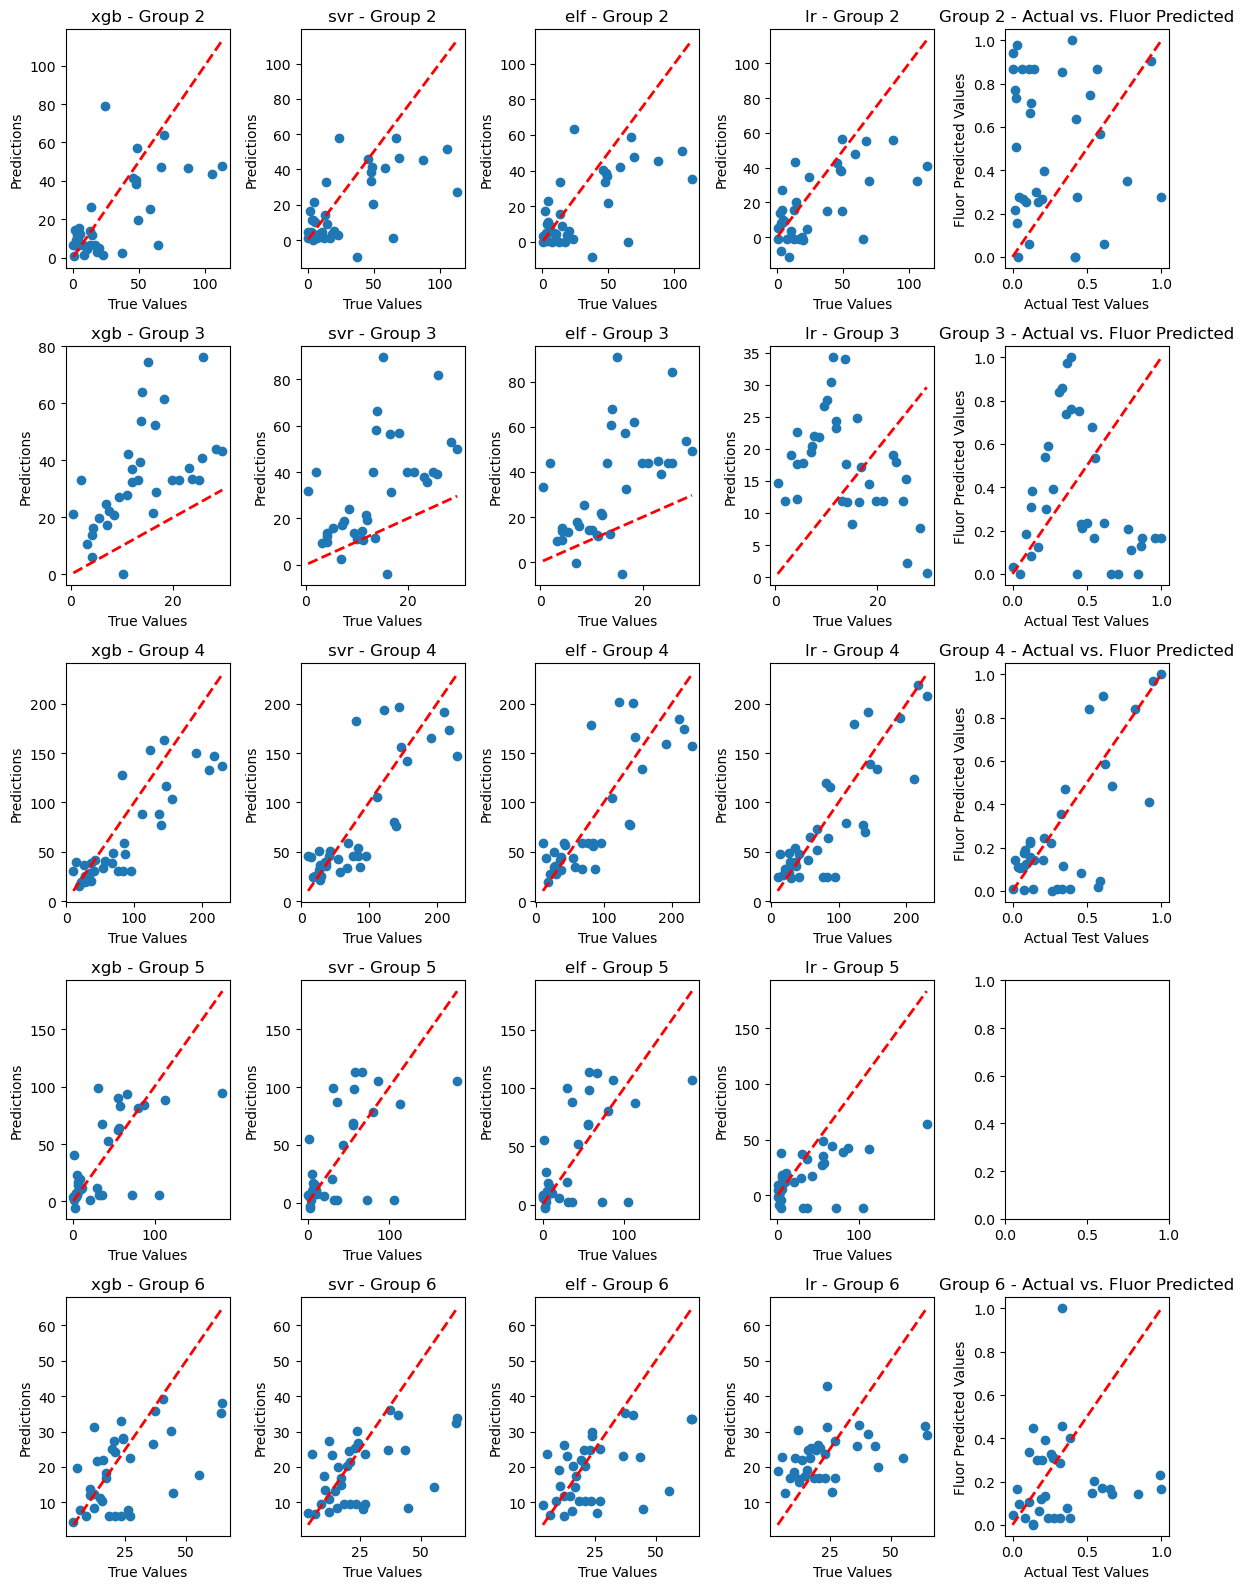

In [47]:
comparing_df = compare_all_models(regression_models, merged_test, fluor_test_df, fluor_groups_map, biomass_factor=100)

In [48]:
comparing_df.groupby('Model')[['RMSE', 'R-squared']].mean()

RMSE  R-squared
Model                     
FP     0.380041  -1.169304
elf    0.263600  -0.137580
lr     0.290624  -0.378307
svr    0.269227  -0.168313
xgb    0.244845  -0.014713

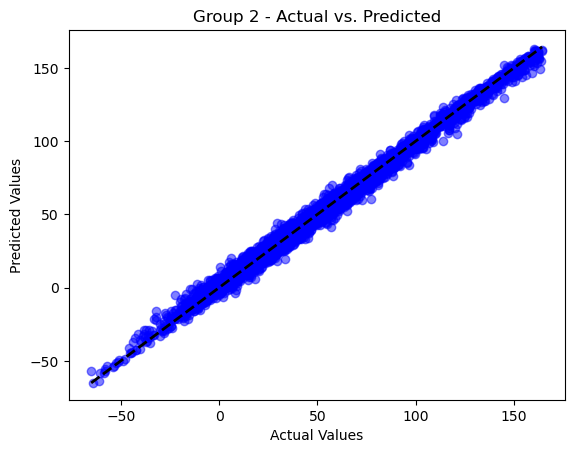

Results for group_num 2:
MSE: 7.126811831946572
R-squared: 0.9949598042345644



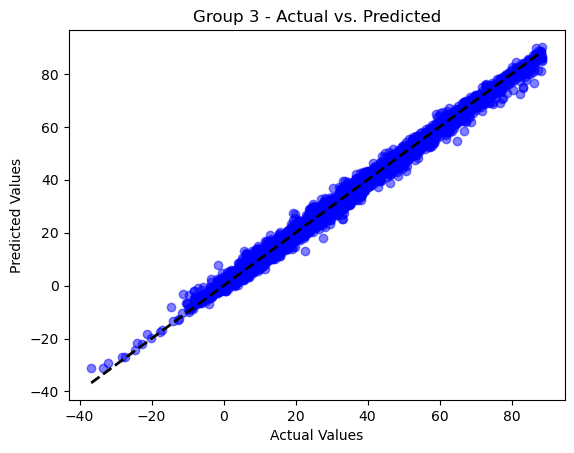

Results for group_num 3:
MSE: 1.9683789870372674
R-squared: 0.9952588099813773



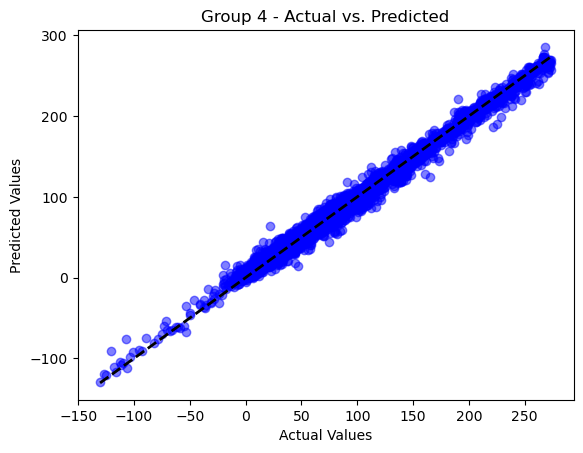

Results for group_num 4:
MSE: 28.079330695142467
R-squared: 0.9912705567501394



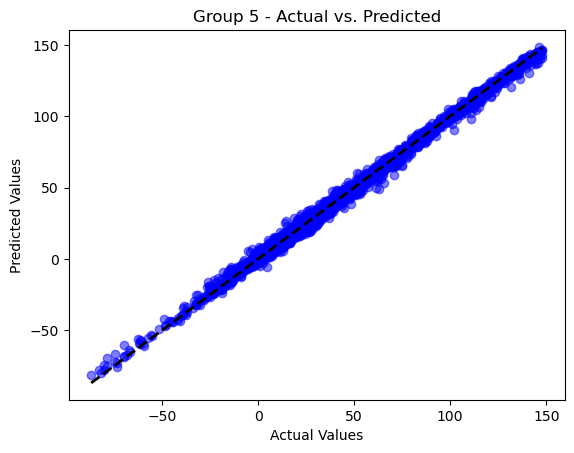

Results for group_num 5:
MSE: 3.320565911952188
R-squared: 0.9967166354299197



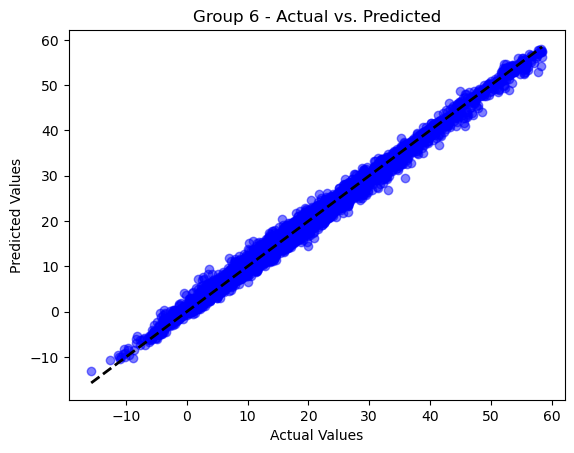

Results for group_num 6:
MSE: 0.8987311160139637
R-squared: 0.9930500113500476

Total MSE: 8.278763708418492, Total R-squared: 0.9942511635492096


In [49]:
eval_test(regression_models['xgb'], merged_train, biomass_factor=100)

## Linear Regression

In [ ]:
regression_models['lr'], _ = train('lr', merged_df, test_size=0.0, biomass_factor=100)

In [37]:
# eval_test(regression_models_lr, merged_df_test, biomass_factor=100)

In [38]:
# residual_analysis(merged_df_test, regression_models_lr, biomass_factor=100)

## XGBoost

In [54]:
# keep_cols = merged_df.columns

In [55]:
# from sklearn.feature_selection import SelectKBest, f_regression
# selkbest= SelectKBest(f_regression, k=5)
# X_new = selkbest.fit_transform(merged_df.drop('sum_biomass_ug_ml', axis=1), merged_df['sum_biomass_ug_ml'])

In [56]:
# selkbest.get_feature_names_out()

In [57]:
# keep_cols = ['orange', 'brown', 'blue', 'Total conc', 'group_num', 'sum_biomass_ug_ml']

In [60]:
# regression_models_xgboost, preds_real_y_xgboost = train('xgb', merged_df, test_size=0.0, biomass_factor=100)

In [ ]:
# eval_test(regression_models_xgboost, merged_df_test, biomass_factor=100)

In [ ]:
# compare_to_fluor(regression_models_xgboost, merged_df_test, fluor_groups_map, fluor_test_df, biomass_factor=100)

In [ ]:
# residual_analysis(merged_df_test, regression_models_xgboost, biomass_factor=100)

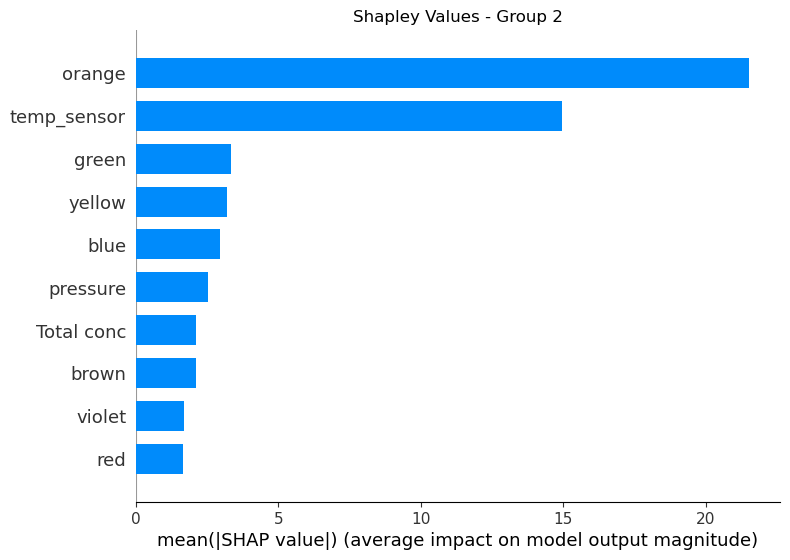

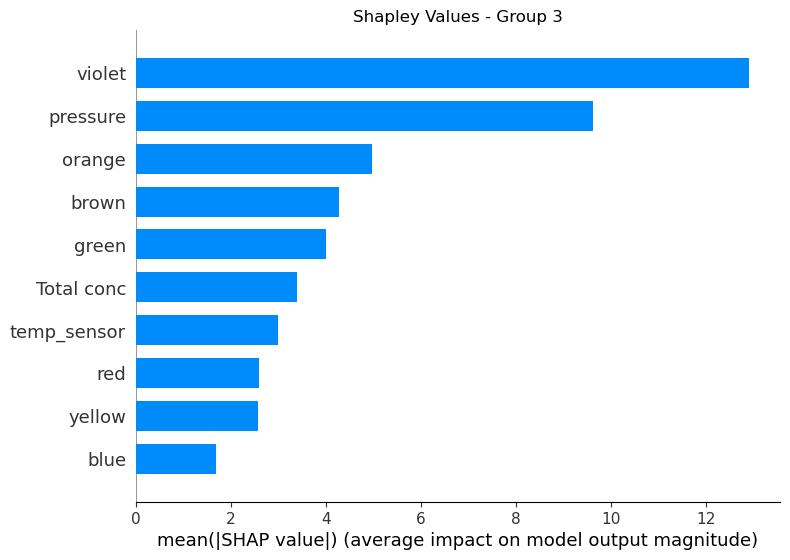

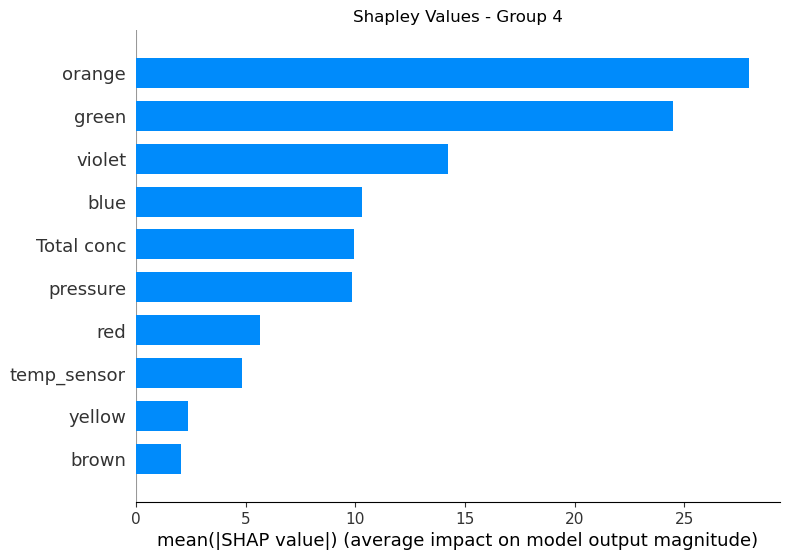

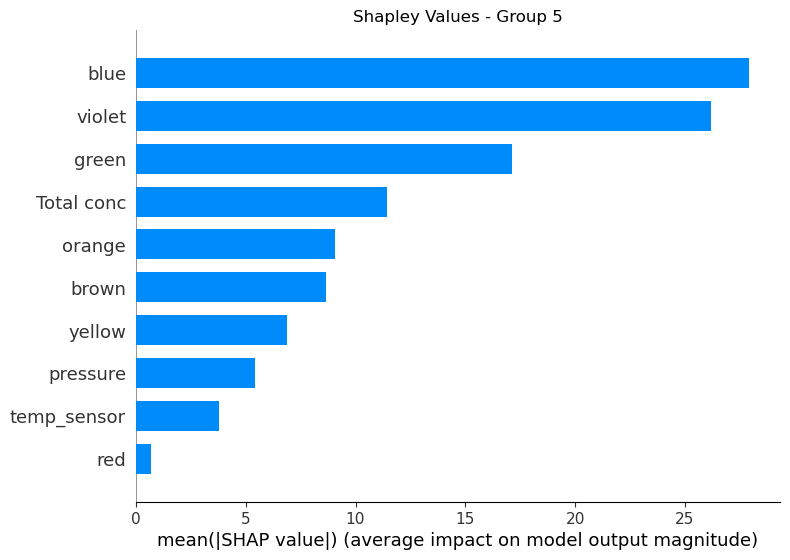

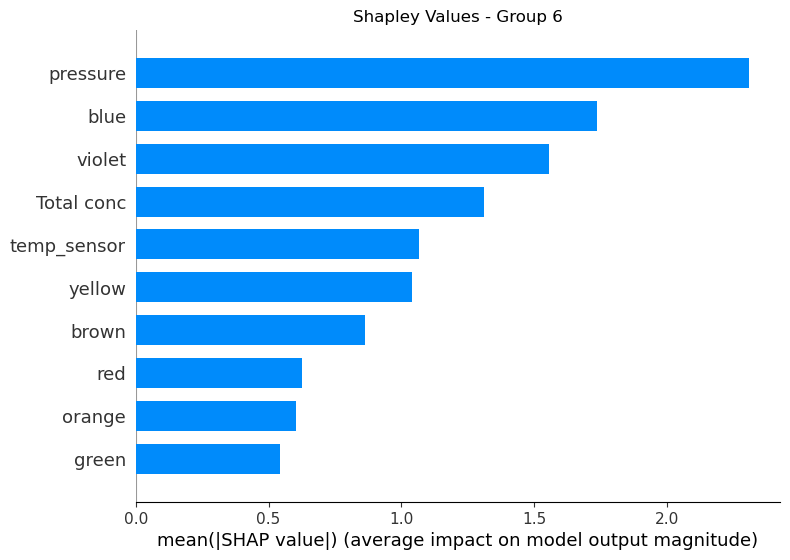

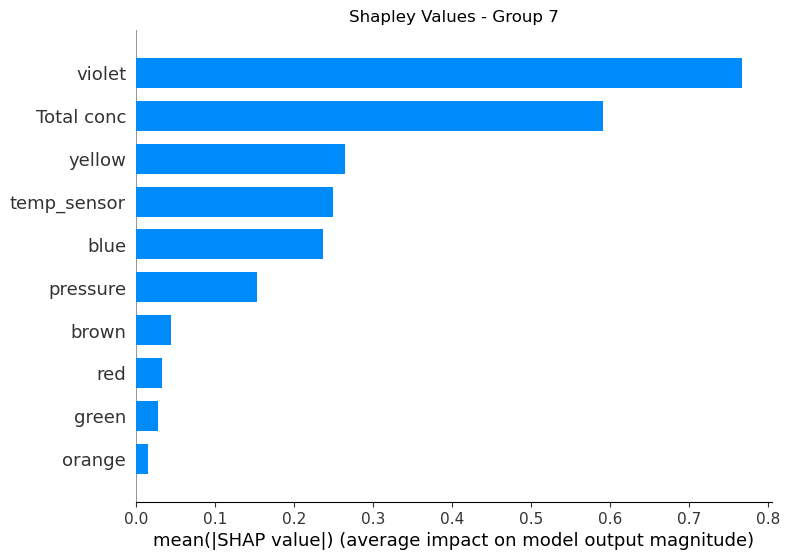

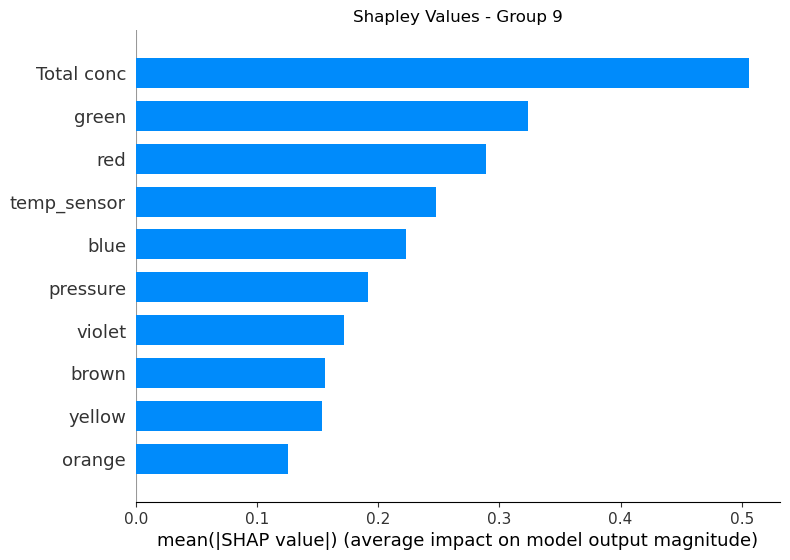

In [74]:
shap_values_list = plot_shap_values(merged_df_test, regression_models_xgboost, merged_df_test)

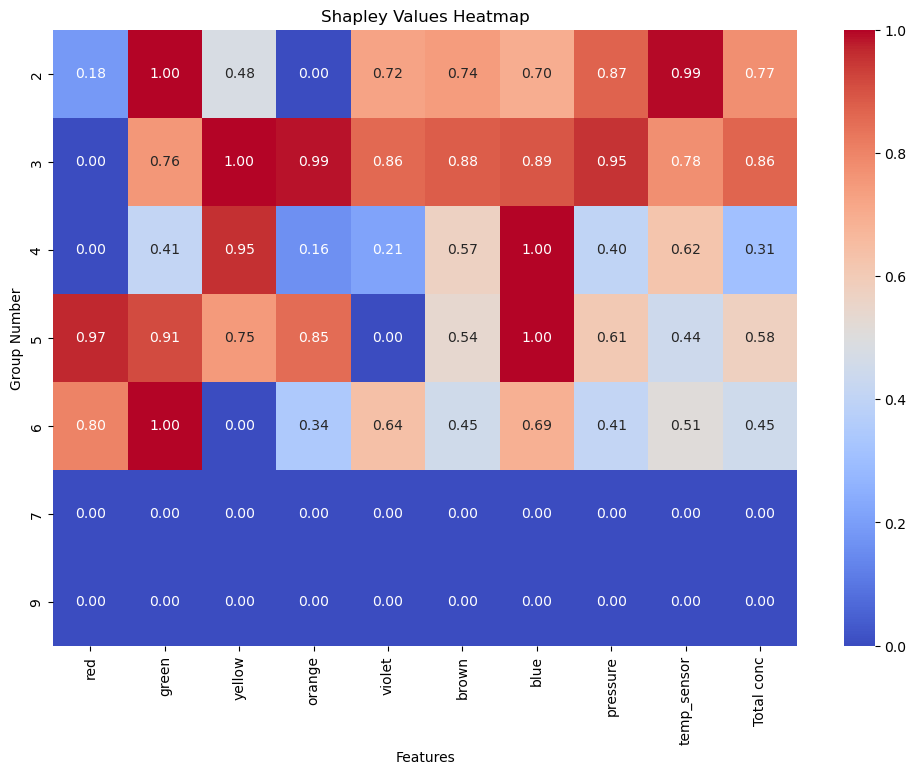

In [83]:
features_list = merged_df_test.drop(['group_num', 'sum_biomass_ug_ml'], axis=1).columns.tolist()

# Create a DataFrame from the Shapley values
shap_df = pd.DataFrame({k: np.average(v.values, axis=0) for k, v in shap_values_list.items()}, index=features_list)

scaler = MinMaxScaler()
scaled_shap_df = pd.DataFrame(scaler.fit_transform(shap_df), columns=shap_df.columns, index=shap_df.index)
    
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(scaled_shap_df.transpose(), cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Shapley Values Heatmap")
plt.xlabel("Features")
plt.ylabel("Group Number")
plt.show()


## SVR

In [101]:
# regression_models_svr, preds_real_y_xgboost = train('svr', merged_df, test_size=0.0, biomass_factor=100, group_kwargs=group_kwargs)

In [ ]:
# eval_test(regression_models_svr, merged_df_test, biomass_factor=100)

In [ ]:
# compare_to_fluor(regression_models_svr, merged_df_test, fluor_groups_map, fluor_test_df, biomass_factor=100)

## ElasticNet Regression

In [ ]:
# regression_models_elf, preds_real_y_xgboost = train('elf', merged_df, test_size=0.0, biomass_factor=100)

In [ ]:
# eval_test(regression_models_elf, merged_df_test, biomass_factor=100)

In [ ]:
# compare_to_fluor(regression_models_elf, merged_df_test, fluor_groups_map, fluor_test_df, biomass_factor=100)